In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
#================================================================================
#核心逻辑：将数据分成数值型的以及描述型的特征，再对数值型的特征进行“统一数据词典”上我标注的变换
#================================================================================
# ==============================================================================
# 1. 加载数据
# ==============================================================================
df = pd.read_csv('SQL的最终取数_我们的分析数据.csv')
print("数据加载成功，原始数据维度: ", df.shape)


# ==============================================================================
# 2. 定义特征列（根据“统一数据词典”和我们的分析）
# ==============================================================================
# 需要进行对数变换的数值型表现类标签
log_transform_cols = [
    'total_account_count', 'month_avg_account_count', 'total_ad_count',
    'month_avg_ad_count', 'total_campaign_count', 'month_avg_campaign_count',
    'month_avg_topup_amt', 'month_avg_topup_cnt', 'month_avg_spendaccount_num',
    'month_avg_spend_amt', 'first_30d_topup_amt', 'first_7d_spend_usd',
    'd8_to_d30_spend_usd', 'd31_to_d60_spend_usd', 'd61_to_d90_spend_usd',
    'd91_plus_spend_usd', 'last_7d_spend_usd', 'last_d8_to_d30_spend_usd',
    'last_d31_to_d60_spend_usd', 'last_d61_to_d90_spend_usd',
    'last_d91_plus_spend_usd', 'max_month_spendbyfirst_month_spend',
    'max_month_spendbylast_month_spend', 'month_std2avg',
    'financial_runway_months', 'ratio_avg_daily_spend_max_to_first',
    'ratio_avg_daily_spend_max_to_last', 'avg_monthly_active_days',
    'avg_monthly_event_count', 'avg_monthly_distinct_l3_count',
    'avg_monthly_distinct_l4_count', 'month_avg_country_count',
    'month_avg_continent_count', 'month_avg_custom_region_count',
    'consumed_level2_category_count', 'consumed_level3_category_count',
    'channel_count'
]

# 比例型数值标签（0-1之间），无需对数变换
ratio_cols = [
    'spendacc2applyopen_ratio', 'value_concentration_index',
    'value_concentration_index_daily', 'fb_spend_by_full_spend_ratio',
    'tt_spend_by_full_spend_ratio', 'gg_spend_by_full_spend_ratio',
    'fb_tt_gg_spend_by_full_spend_ratio', 'top_custom_region_spend_ratio'
]

# 有序分类型（Ranked）标签及其顺序
ordinal_cols_mapping = {
    'onboarding_intent_tier': ['90日以上启动投放','90日内启动投放','60日内启动投放', '30日内启动投放', '15日内启动投放', '历史老客']
}


# 判断型（Judgement）标签，已经是0/1格式，或需要转换为0/1
# 这些是我们之前用SQL生成的标签
judgement_cols = [
    'is_core_category_clothing', 'is_core_category_accessories',
    'is_core_category_beauty', 'is_core_category_electronics',
    'core_feature_adoption_flag', 'has_high_risk_flag_gambling',
    'has_high_risk_flag_real_money', 'has_high_risk_flag_counterfeit',
    'has_high_risk_flag_cheat','is_concatenated_equal_to_combined'
]

# 需要从训练中剔除的列
drop_cols_for_descriptions = [
    'corporation_id', 'corporation_name',
    'top_l2_category',
    'top_l2_l3_combined', 
    'top_custom_region_all', 'top_custom_region_fb', 'top_custom_region_tt',
    'top_custom_region_gg', 'main_regions','corporation_promotion_channel_second','main_media'
]
drop_cols = ['top_l2_and_l3_concatenated','corporation_size','business_background','ads_team_size', 'top_l3_category','top_l3_category_feature', 'top_l4_category_feature']

print("特征列定义完成。")
df_transformed = df.copy()

# ==============================================================================
# 3. 执行特征变换
# ==============================================================================
df_descriptive = df[drop_cols_for_descriptions].copy()
print("已备份描述性字段用于后续分析。")
# **【修正点 1 & 3】: 预处理数值列，处理Null值和负值**
# 替换 \N 为标准NaN
df_transformed.replace('\\N', np.nan, inplace=True)

# 处理 financial_runway_months 的负值问题
# 先确保列是数字，无法转换的变为NaN
df_transformed['financial_runway_months'] = pd.to_numeric(df_transformed['financial_runway_months'], errors='coerce')
# 将负值修正为0
df_transformed['financial_runway_months'] = df_transformed['financial_runway_months'].clip(lower=0)
print("已修正 financial_runway_months 中的负值。")
# **【修正点 4】: 编码 'is_concatenated_equal_to_combined' 字段**
judgement_map = {'是': 1, '否': 0, '无法比较': 2}
df_transformed['is_concatenated_equal_to_combined'] = df_transformed['is_concatenated_equal_to_combined'].map(judgement_map).fillna(2)
print("已完成 judgement 字段的编码。")
# **【最终版】: 根据您指定的明确排位边界，对 days_since_last_spend 进行分层编码**
# 先确保列是数字，并用中位数填充可能存在的NaN
df_transformed['days_since_last_spend'] = pd.to_numeric(df_transformed['days_since_last_spend'], errors='coerce').fillna(df_transformed['days_since_last_spend'].median())
# 使用rank()方法计算每个客户的排位。method='first'确保即使值相同，排位也唯一
# 值越小（天数越少），排位越靠前（rank值越小）
ranks = df_transformed['days_since_last_spend'].rank(method='first')
# 定义排位的边界
bin_edges = [
    0,      # rank的起始
    2839,   # 第1个分层的结束排位
    5024,   # 第2个分层的结束排位
    7513,   # 第3个分层的结束排位
    9999    # 总数，即最后一个分层的结束排位
]
# 定义每个分层对应的标签（我们假设是4, 3, 2, 1，代表价值从高到低）
bin_labels = [4, 3, 2, 1]
# 使用pd.cut根据排位进行切分
df_transformed['days_since_last_spend_ranked'] = pd.cut(ranks, bins=bin_edges, labels=bin_labels, right=True)
# 将新生成的ranked列加入标准化列表，并从原log变换列表中移除 
numeric_cols_to_scale = log_transform_cols + ratio_cols + list(ordinal_cols_mapping.keys()) + ['days_since_last_spend_ranked'] # 添加到待标准化列表
print("已完成 days_since_last_spend 的百分比分层编码。")


# **【最终修正】: 对 log_transform_cols 和 ratio_cols 都进行明确的缺失值填充**
for col in log_transform_cols:
    df_transformed[col] = pd.to_numeric(df_transformed[col], errors='coerce').fillna(0)
    df_transformed[col] = np.log1p(df_transformed[col])
print("对数变换完成（已包含Null值处理）。")

for col in ratio_cols:
    df_transformed[col] = pd.to_numeric(df_transformed[col], errors='coerce').fillna(0)
print("比例型特征的缺失值填充完成。")


# 步骤 3.2: 有序变量编码
for col, mapping in ordinal_cols_mapping.items():
    cat_to_int = {category: i+1 for i, category in enumerate(mapping)}
    df_transformed[col] = df_transformed[col].map(cat_to_int).fillna(0)
print("有序变量编码完成。")




# 步骤 3.4: 剔除不需要的列
# 原始的days_since_last_spend也需要剔除
drop_cols_for_descriptions.append('days_since_last_spend')
df_transformed.drop(columns=drop_cols_for_descriptions, inplace=True, errors='ignore')
df_transformed.drop(columns=drop_cols, inplace=True, errors='ignore')
print("无关列剔除完成。")

# 步骤 3.5: 标准化所有数值型特征
# 过滤掉因某些操作（如get_dummies）可能已不存在的列，保证代码稳健性
numeric_cols_to_scale = [col for col in numeric_cols_to_scale if col in df_transformed.columns]

scaler = StandardScaler()
df_transformed[numeric_cols_to_scale] = scaler.fit_transform(df_transformed[numeric_cols_to_scale])
print("数值型特征标准化完成。")


# ==============================================================================
# 4. 完成 - 输出最终结果
# ==============================================================================
feature_set_A = df_transformed
print("\n特征工程构建完毕！")
print("最终用于聚类的特征集A的维度: ", feature_set_A.shape)
print("\n最终特征集A的前5行预览:")
print(feature_set_A.head())
print("\n最终特征集A的列名:")
print(feature_set_A.columns.tolist())

数据加载成功，原始数据维度:  (9999, 76)
特征列定义完成。
已备份描述性字段用于后续分析。
已修正 financial_runway_months 中的负值。
已完成 judgement 字段的编码。
已完成 days_since_last_spend 的百分比分层编码。
对数变换完成（已包含Null值处理）。
比例型特征的缺失值填充完成。
有序变量编码完成。
无关列剔除完成。
数值型特征标准化完成。

特征工程构建完毕！
最终用于聚类的特征集A的维度:  (9999, 58)

最终特征集A的前5行预览:
   total_account_count  month_avg_account_count  total_ad_count  \
0            -1.135808                -0.872927       -1.813041   
1            -0.646157                -0.384743       -0.801124   
2            -0.548727                -0.467698       -0.496248   
3            -0.548727                -0.670313        0.072066   
4            -1.135808                -0.872927       -0.504486   

   month_avg_ad_count  total_campaign_count  month_avg_campaign_count  \
0           -1.636678             -1.745381                 -1.539203   
1           -0.646642             -1.274203                 -1.137630   
2           -0.445777             -0.803026                 -0.786466   
3            0.031450              0.07056

In [2]:
#===========================================
# 多重共线性诊断，核心逻辑是发现共线性下的每一团簇以找到最符合业务的核心特征，每个簇选择1-2个就好。
#===========================================
print("--- 开始进行多重共线性诊断 ---")
# **【核心修正】: 设置Pandas显示选项，以完整展示所有结果**
pd.set_option('display.max_rows', None)    # 不限制最大行数
pd.set_option('display.max_columns', None) # 不限制最大列数
pd.set_option('display.width', 200)        # 设置每行的宽度，防止换行
# 1. 计算相关性矩阵
# 我们只关心相关性的强度，所以取绝对值
corr_matrix = feature_set_A.corr().abs()

# 2. 可视化热力图 (可选，但推荐)
# 由于特征太多，完整的热力图可能难以阅读，但可以宏观感受相关性强度
# plt.figure(figsize=(20, 20))
# sns.heatmap(corr_matrix, cmap='viridis')
# plt.title("完整特征集A的相关性热力图", fontsize=16)
# plt.show()

# 3. 找出并组合高度相关的特征“簇”
correlation_threshold = 0.8  # 定义一个阈值，例如相关性大于0.8的我们认为是高度相关
print(f"\n正在寻找相关性 > {correlation_threshold} 的特征簇...")

# 创建一个上三角矩阵，避免重复比较 (A-B 和 B-A)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 找到所有高于阈值的特征对
highly_correlated_pairs = [column for column in upper_tri.columns if any(upper_tri[column] > correlation_threshold)]
highly_correlated_features = upper_tri[highly_correlated_pairs]

# 将这些特征对组合成“簇”
correlated_groups = []
for col in highly_correlated_features.columns:
    # 找到与当前列高度相关的其他列
    related_cols = highly_correlated_features[col][highly_correlated_features[col] > correlation_threshold].index.tolist()
    
    # 将当前列也加入
    related_cols.append(col)
    
    # 检查这个新发现的组是否已经存在于我们的总列表中
    is_new_group = True
    for group in correlated_groups:
        # 如果新组和某个老组有交集，就合并它们，并且标记为非新组
        if any(item in group for item in related_cols):
            group.update(related_cols)
            is_new_group = False
            break
            
    # 如果是全新的组，就添加它
    if is_new_group:
        correlated_groups.append(set(related_cols))

print(f"\n诊断完成！共找到 {len(correlated_groups)} 个高度相关的特征簇：")
print("\n--- 正在显示第 1-3 个簇 ---")

# ==============================================================================
# Cell 1/3: 打印第1至3个簇
# ==============================================================================
for i in range(0, 3):
    group = correlated_groups[i]
    group_list = sorted(list(group))
    for j in range(0, len(group_list), 5):
        print("  ".join(group_list[j:j+5]))
    print("\n簇内相关性矩阵:")
    print(corr_matrix.loc[group_list, group_list].to_string())

--- 开始进行多重共线性诊断 ---

正在寻找相关性 > 0.8 的特征簇...

诊断完成！共找到 9 个高度相关的特征簇：

--- 正在显示第 1-3 个簇 ---
month_avg_account_count  month_avg_spendaccount_num  total_account_count

簇内相关性矩阵:
                            month_avg_account_count  month_avg_spendaccount_num  total_account_count
month_avg_account_count                    1.000000                    0.951118             0.867424
month_avg_spendaccount_num                 0.951118                    1.000000             0.860437
total_account_count                        0.867424                    0.860437             1.000000
month_avg_ad_count  month_avg_campaign_count  total_ad_count  total_campaign_count

簇内相关性矩阵:
                          month_avg_ad_count  month_avg_campaign_count  total_ad_count  total_campaign_count
month_avg_ad_count                  1.000000                  0.902463        0.929896              0.836425
month_avg_campaign_count            0.902463                  1.000000        0.833952              0.896053
total

In [3]:
# ==============================================================================
# Cell 2/3: 打印第4至6个簇
# ==============================================================================

# 假设 correlated_groups 和 corr_matrix 变量已在上一单元格成功创建
print("\n--- 正在显示第 4-6 个簇 ---")

# 打印第4至6个簇
for i in range(3, 6):
    group = correlated_groups[i]
    group_list = sorted(list(group))
    for j in range(0, len(group_list), 5):
        print("  ".join(group_list[j:j+5]))
    print("\n簇内相关性矩阵:")
    print(corr_matrix.loc[group_list, group_list].to_string())


--- 正在显示第 4-6 个簇 ---
d91_plus_spend_usd  last_d91_plus_spend_usd

簇内相关性矩阵:
                         d91_plus_spend_usd  last_d91_plus_spend_usd
d91_plus_spend_usd                 1.000000                 0.975312
last_d91_plus_spend_usd            0.975312                 1.000000
max_month_spendbyfirst_month_spend  ratio_avg_daily_spend_max_to_first

簇内相关性矩阵:
                                    max_month_spendbyfirst_month_spend  ratio_avg_daily_spend_max_to_first
max_month_spendbyfirst_month_spend                            1.000000                            0.941645
ratio_avg_daily_spend_max_to_first                            0.941645                            1.000000
max_month_spendbylast_month_spend  ratio_avg_daily_spend_max_to_last

簇内相关性矩阵:
                                   max_month_spendbylast_month_spend  ratio_avg_daily_spend_max_to_last
max_month_spendbylast_month_spend                           1.000000                           0.958231
ratio_avg_daily_spend_max_to

In [4]:
# ==============================================================================
# Cell 3/3: 打印第7至9个簇
# ==============================================================================

# 假设 correlated_groups 和 corr_matrix 变量已在之前单元格成功创建
print("\n--- 正在显示第 7-9 个簇 ---")

# 打印第7至9个簇
for i in range(6, 9):
    group = correlated_groups[i]
    group_list = sorted(list(group))
    for j in range(0, len(group_list), 5):
        print("  ".join(group_list[j:j+5]))
    print("\n簇内相关性矩阵:")
    print(corr_matrix.loc[group_list, group_list].to_string())


--- 正在显示第 7-9 个簇 ---
avg_monthly_active_days  avg_monthly_distinct_l3_count  avg_monthly_distinct_l4_count  avg_monthly_event_count  core_feature_adoption_flag

簇内相关性矩阵:
                               avg_monthly_active_days  avg_monthly_distinct_l3_count  avg_monthly_distinct_l4_count  avg_monthly_event_count  core_feature_adoption_flag
avg_monthly_active_days                       1.000000                       0.629646                       0.716948                 0.889388                    0.670543
avg_monthly_distinct_l3_count                 0.629646                       1.000000                       0.929264                 0.768015                    0.726653
avg_monthly_distinct_l4_count                 0.716948                       0.929264                       1.000000                 0.855785                    0.819568
avg_monthly_event_count                       0.889388                       0.768015                       0.855785                 1.000000        

In [5]:
# ===============================================================================
# 决定剔除的特征列表里有我筛选的剔除的（根据前面每个簇里找到需要删掉的，也就是选出来的特征剩下的），不过我最终没有完成这一步是因为PCA本身就会
# 处理共线性问题，所以我决定不手动剔除特征。当然也可以选择剔除这些字段再用其他的处理方法，所以提出来。我试下来直接使用PCA降维反而后面模型表现力还好一点。
# ===============================================================================
# ==============================================================================
# 下一步：您的决策与操作
# ==============================================================================
print("\n\n" + "#"*60)
print("       所有特征簇已显示完毕，请开始您的决策")
print("#"*60)
cols_to_drop_for_collinearity =[]
# 在您审阅了所有输出后，需要定义一个您决定要剔除的列的列表
#cols_to_drop_for_collinearity = [
    # --- 请在这里填入您决定要删除的列名 ---
    # 例如: 'month_avg_account_count', 
    #       'total_ad_count',
    #'month_avg_account_count','total_account_count','month_avg_campaign_count',  'total_ad_count',  'total_campaign_count',
    #'first_30d_topup_amt','month_avg_topup_amt','last_d91_plus_spend_usd','ratio_avg_daily_spend_max_to_first','ratio_avg_daily_spend_max_to_last',
    #'avg_monthly_event_count','avg_monthly_distinct_l4_count','avg_monthly_distinct_l3_count','month_avg_continent_count','consumed_level2_category_count','consumed_level3_category_count'
#]

if cols_to_drop_for_collinearity:
    feature_set_A_manual_reduced = feature_set_A.drop(columns=cols_to_drop_for_collinearity)
    print(f"\n已根据您的选择，剔除了 {len(cols_to_drop_for_collinearity)} 个高共线性特征。")
    print(f"手动降维后的新特征集维度: {feature_set_A_manual_reduced.shape}")
    print("接下来，您可以对 'feature_set_A_manual_reduced' 这个新的DataFrame进行PCA降维。")
else:
    print("\n您尚未定义要剔除的列。后续的PCA将会在原始的 feature_set_A 上进行。")



############################################################
       所有特征簇已显示完毕，请开始您的决策
############################################################

您尚未定义要剔除的列。后续的PCA将会在原始的 feature_set_A 上进行。


In [6]:
# =============================================================
# 将这个处理后的数值型的table，命名为 feature_set_A_pca，预备后面做PCA。
# =============================================================
# 将我们最终的特征集A保存为一个名为 feature_set_A_output.csv 的文件
# index=False 表示我们不需要将DataFrame的行索引也写入到文件中
feature_set_A.to_csv('feature_set_A_output.csv', index=False)

print("\n已成功将完整的预处理后数据导出为 'feature_set_A_output.csv' 文件。")
print("您现在可以用Excel或WPS等软件打开它，进行详细的审阅。")


已成功将完整的预处理后数据导出为 'feature_set_A_output.csv' 文件。
您现在可以用Excel或WPS等软件打开它，进行详细的审阅。


\n--- 诊断：计算特征集A的相关性矩阵 ---


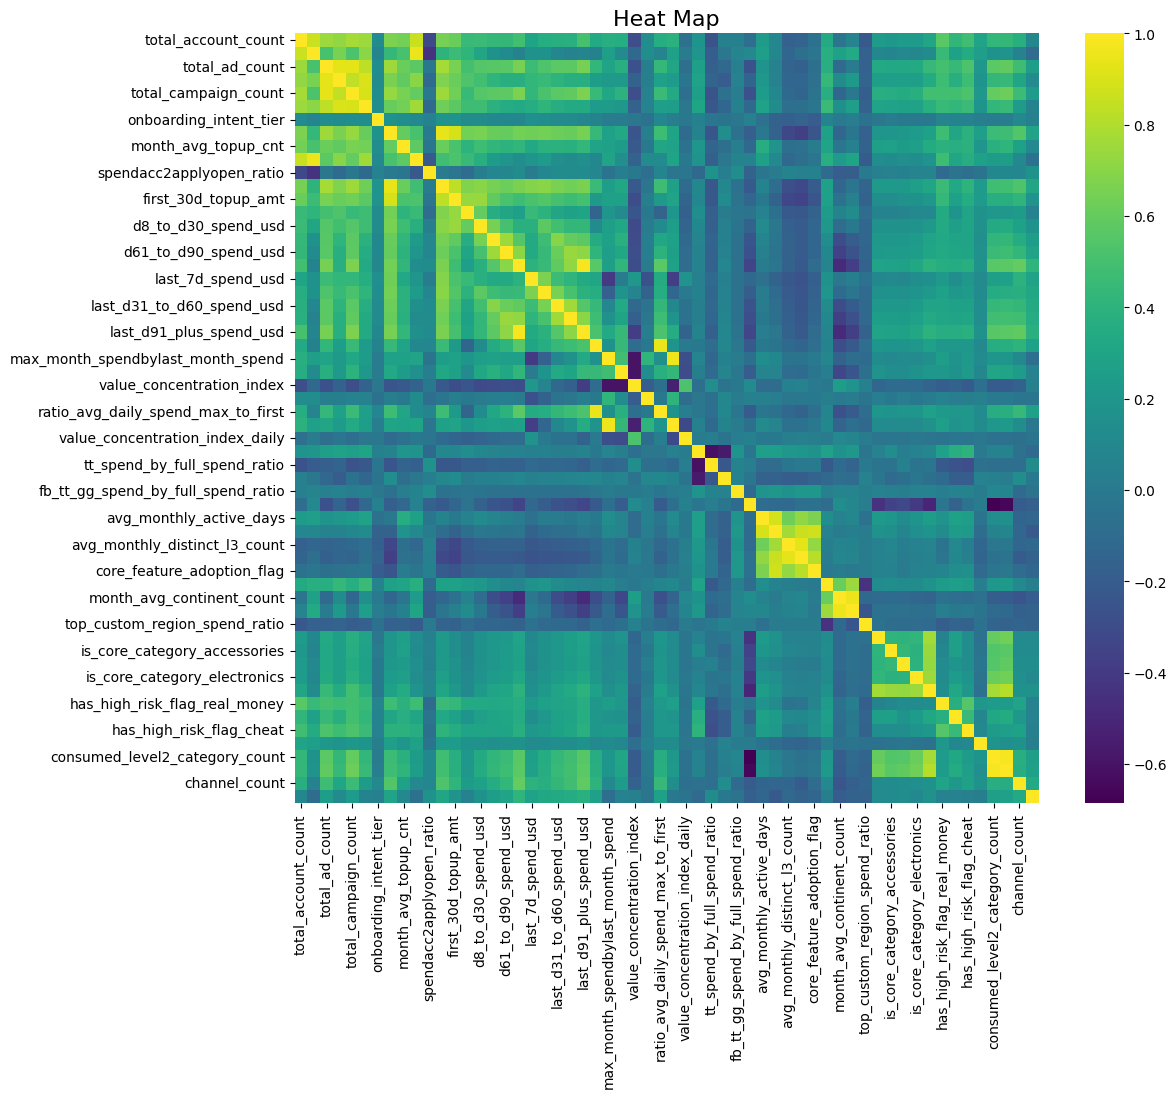

热力图中的亮色区域代表高度正相关，这证明了PCA的必要性。


In [7]:
# ==============================================================
# 画出一个特征间相关性的热力图，先看一下PCA前所有特征整体的共线性情况如何，其实还好：整体不是都特别高
# 当然，上面那个版本剔除了我写的字段的版本我也画了热力图，会发现共线性更低，但是再PCA后反而效果不如直接PCA好，可以考虑其他方法或者不用PCA。
# ==============================================================
import seaborn as sns
import matplotlib.pyplot as plt

# --- 诊断步骤：可视化特征间的相关性 ---
print("\\n--- 诊断：计算特征集A的相关性矩阵 ---")

# 计算相关性矩阵
correlation_matrix = feature_set_A.corr()

# 使用热力图进行可视化
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='viridis')
plt.title("Heat Map", fontsize=16)
plt.show()

print("热力图中的亮色区域代表高度正相关，这证明了PCA的必要性。")

中文字体设置成功: SimHei

开始执行PCA降维分析...


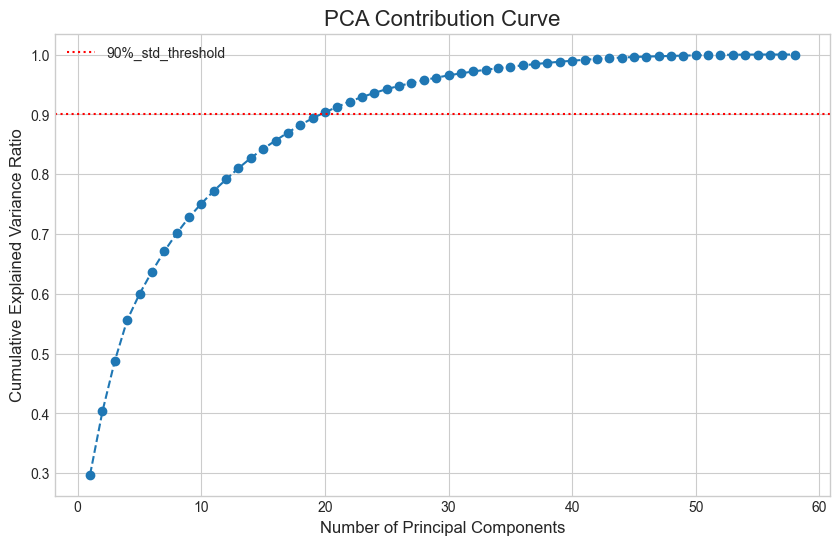


为了保留至少 90% 的原始信息，我们建议选择 19 个主成分。

已成功生成新的低维度特征集 feature_set_A_pca。
降维后的数据维度:  (9999, 19)

降维后特征集的前5行预览:
       PC_1      PC_2      PC_3      PC_4      PC_5      PC_6      PC_7      PC_8      PC_9     PC_10     PC_11     PC_12     PC_13     PC_14     PC_15     PC_16     PC_17     PC_18     PC_19
0 -0.070815 -4.364053 -6.366564  1.281231 -1.931796 -1.679938  0.133194  0.355999 -0.229834 -5.535631 -3.163250 -4.249657  2.467827  1.213613 -0.477387 -4.454670 -1.167850  0.061670 -0.192285
1 -4.362881 -0.935494  0.466502 -0.834439  0.024303 -0.421085 -1.687122 -0.972143  1.312188 -1.063815  0.033051 -0.029848 -1.819231  0.064037  0.469128  0.292090 -0.750425  0.657647  1.005155
2 -1.551357 -0.220372  0.050563  0.528060 -3.322350 -0.919939 -0.110998  0.918577 -0.401743  0.411409  0.205278 -1.280657  0.175681 -0.479726  0.541864  0.351106 -0.191327 -0.383713 -0.766660
3  0.414038 -0.558552  1.404255 -2.685289 -2.368289  0.130871  0.712973 -0.062732  0.216061  0.329522  1.037432 -0.511363 -0.11

In [8]:
# ==========================================
# 画出PCA贡献度的图，选择超过90%方差贡献的主成分，选择前19个。
# ==========================================
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# ==============================================================================
# 解决 Matplotlib 中文显示问题
# ==============================================================================

# 尝试设置一个常见的支持中文的字体
# Windows系统通常有'SimHei', 'Microsoft YaHei'
# MacOS系统通常有'Arial Unicode MS', 'Heiti TC'
# Linux系统则需要看具体安装了哪些中文字体
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False # 解决负号'-'显示为方块的问题
print("中文字体设置成功: SimHei")
# ==============================================================================
# 5. 【新增】PCA降维分析
# ==============================================================================
print("\n开始执行PCA降维分析...")

# 步骤 5.1: 应用PCA来分析所有可能的主成分
# 此时不设置n_components，以便获取所有主成分的方差解释率
pca_analyzer = PCA()
# 确保所有数据都是数值型，以防万一
feature_set_A = feature_set_A.astype(float)
pca_analyzer.fit(feature_set_A)

# 步骤 5.2: 计算累计方差贡献率
cumulative_variance_ratio = np.cumsum(pca_analyzer.explained_variance_ratio_)

# 步骤 5.3: 绘制累计方差贡献率曲线
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance Ratio', fontsize=12)
plt.title('PCA Contribution Curve', fontsize=16)
plt.grid(True)

# 增加参考线，例如我们希望保留90%的方差
plt.axhline(y=0.90, color='r', linestyle=':', label='90%_std_threshold')
plt.legend(loc='best')
plt.show()

# 步骤 5.4: 自动确定达到方差阈值所需的最少主成分数量
variance_threshold = 0.90
# 使用np.argmax找到第一个满足条件的索引
n_components_needed = np.argmax(cumulative_variance_ratio >= variance_threshold)
print(f"\n为了保留至少 {variance_threshold*100:.0f}% 的原始信息，我们建议选择 {n_components_needed} 个主成分。")


# ==============================================================================
# 6. 【新增】生成最终的低维度特征集
# ==============================================================================

# 步骤 6.1: 使用我们确定的最佳主成分数量来初始化一个新的PCA模型
final_pca = PCA(n_components=n_components_needed)

# 步骤 6.2: 对 feature_set_A 进行拟合和变换，生成新的低维数据集
feature_set_A_pca = final_pca.fit_transform(feature_set_A)

# 步骤 6.3: 查看降维后的结果
print(f"\n已成功生成新的低维度特征集 feature_set_A_pca。")
print("降维后的数据维度: ", feature_set_A_pca.shape)
print("\n降维后特征集的前5行预览:")
# 为了方便查看，我们将其转为DataFrame
df_pca = pd.DataFrame(feature_set_A_pca, columns=[f'PC_{i+1}' for i in range(n_components_needed)])
print(df_pca.head())

In [9]:
# ================================================
# 准备好所有需要的模型库，后面选择最佳模型时直接调用，还有画轮廓系数和BIC图的库
# ================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import dendrogram, linkage
from minisom import MiniSom

# 设置绘图风格和忽略不必要的警告
plt.style.use('seaborn-v0_8-whitegrid')
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

--- 阶段二：探索性分析 - 层次聚类 ---
树状图已生成，请观察并根据主要分叉来判断可能的K值范围。


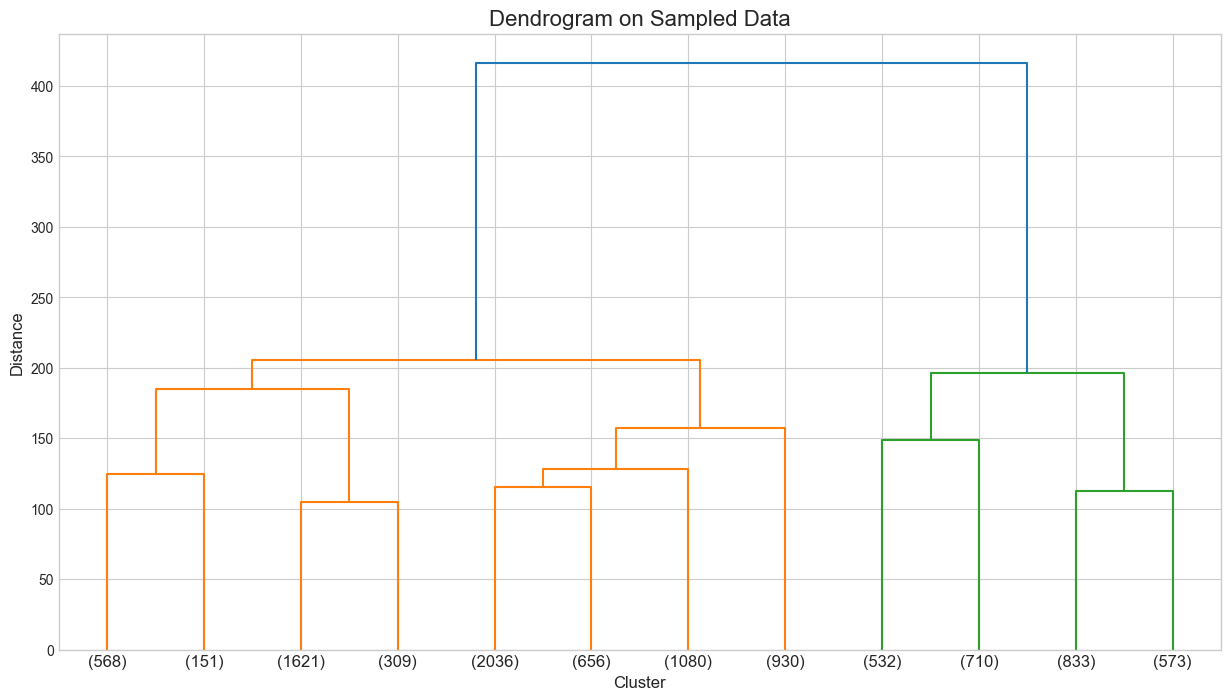

In [10]:
# ==============================================================================
# 先用层次聚类的方法观察一下pca后的数据大概分群是什么样的，树的模型可以直观看，然后和业务团队谈了一些，主要是K = 3,4
# K suggested is k = 3,4
# 我们的客户数据存在着非常清晰的、2至4层的宏观结构。
# ==============================================================================
# ==============================================================================
# 2. 探索性分析：层次聚类
# ==============================================================================
print("--- 阶段二：探索性分析 - 层次聚类 ---")

# 使用'ward'方法进行层次聚类，它倾向于发现大小相似的簇
linked = linkage(feature_set_A_pca, method='ward')

# 绘制树状图
plt.figure(figsize=(15, 8))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
           truncate_mode='lastp', # 显示最后p个合并的簇
           p=12 # p的值可以调整，以便观察主要的枝干
           )
plt.title('Dendrogram on Sampled Data', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Distance', fontsize=12)
print("树状图已生成，请观察并根据主要分叉来判断可能的K值范围。")
plt.show()

中文字体设置成功: SimHei
--- 阶段二：核心模型擂台赛 (扩展版) ---
正在测试 K = 2...
正在测试 K = 3...
正在测试 K = 4...
正在测试 K = 5...
模型循环测试完成！

--- DBSCAN 专项分析 ---
DBSCAN 自主发现的簇数量: 7
DBSCAN 识别出的噪音点数量: 2039 (占总数的 20.39%)
DBSCAN (在非噪音点上) 的轮廓系数: 0.0064

--- 阶段三：结果可视化与决策 ---


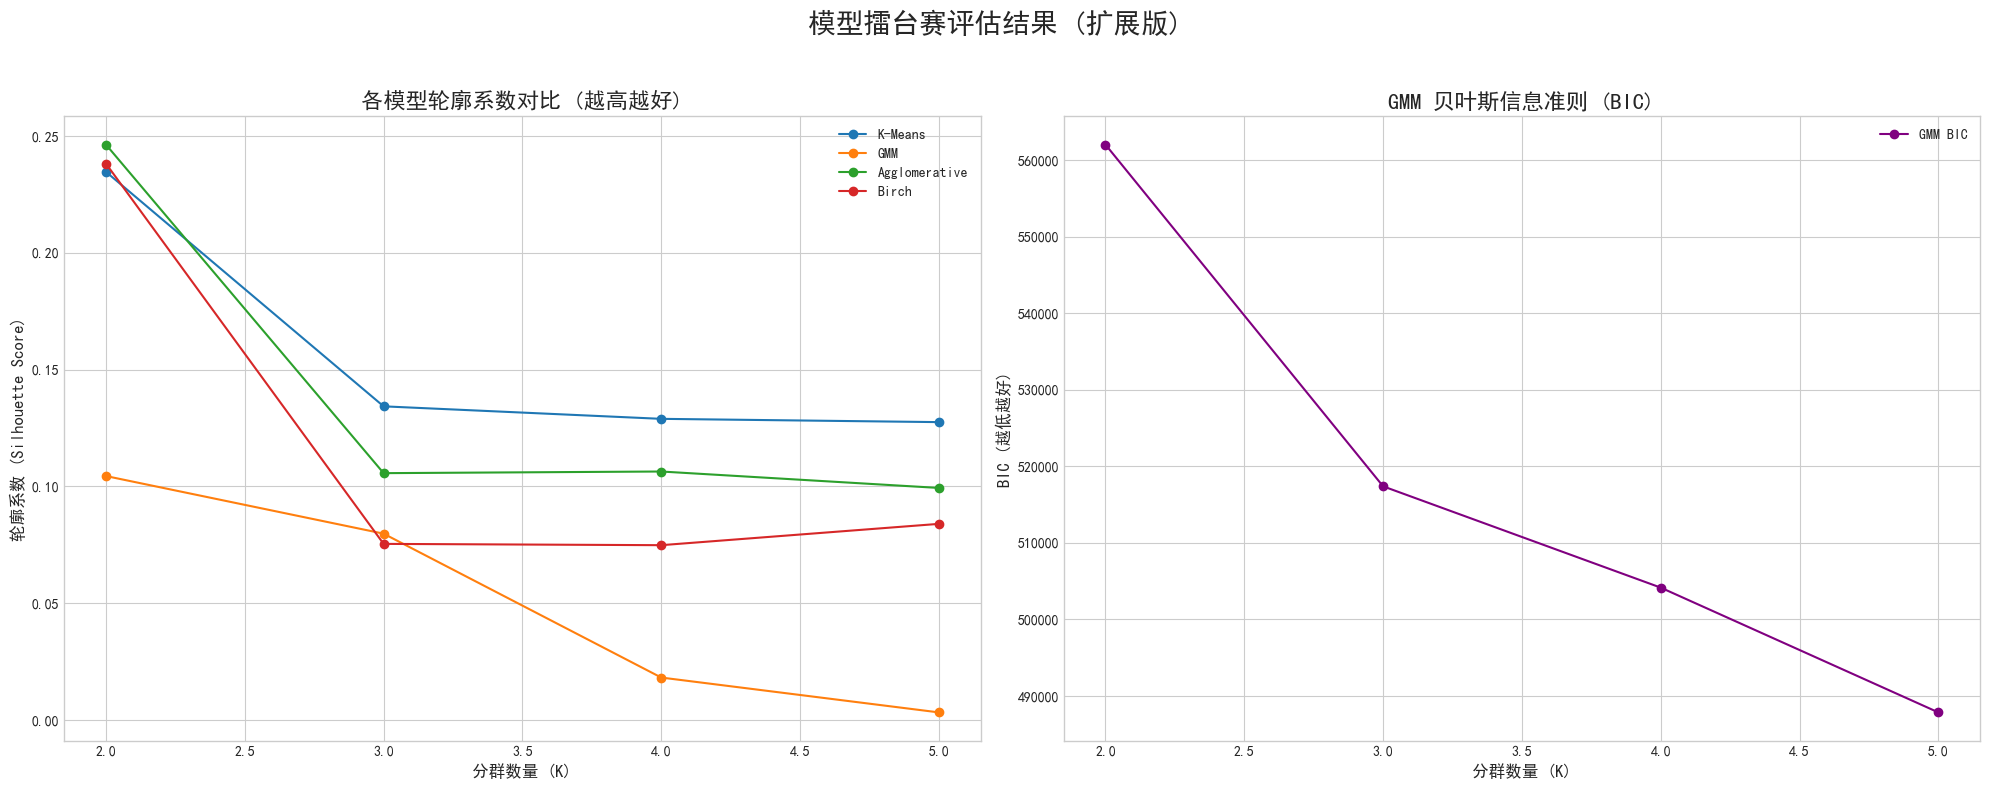


模型评估完成。请综合轮廓系数图、BIC图以及DBSCAN的发现，来确定最终的优胜方案。


In [11]:
# ==============================================================================
# 选择了很多聚类模型进行对比，在还没考虑DBSCAN的情况下发现：Kmeans模型是在所有K上表现最好的。
# ==============================================================================
# ==============================================================================
# 0. 导入所有必要的库 (新增了聚类模型)
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch, DBSCAN # 新增模型
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import dendrogram, linkage
from minisom import MiniSom

# 设置绘图风格和忽略不必要的警告
plt.style.use('seaborn-v0_8-whitegrid')
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False # 解决负号'-'显示为方块的问题
print("中文字体设置成功: SimHei")


# ==============================================================================
# 2. 核心模型竞赛 (已扩展)
# ==============================================================================
print("--- 阶段二：核心模型擂台赛 (扩展版) ---")
k_range = range(2, 6)
results = {
    'k': list(k_range),
    'kmeans_silhouette': [],
    'gmm_silhouette': [],
    'gmm_bic': [],
    'agg_silhouette': [], # 新增
    'birch_silhouette': [], # 新增
}

eval_sample_indices = np.random.choice(feature_set_A_pca.shape[0], 2000, replace=False)
eval_sample = feature_set_A_pca[eval_sample_indices]

for k in k_range:
    print(f"正在测试 K = {k}...")
    
    # K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_kmeans = kmeans.fit_predict(feature_set_A_pca)
    results['kmeans_silhouette'].append(silhouette_score(eval_sample, labels_kmeans[eval_sample_indices]))

    # GMM
    gmm = GaussianMixture(n_components=k, random_state=42, n_init=5)
    labels_gmm = gmm.fit_predict(feature_set_A_pca)
    results['gmm_silhouette'].append(silhouette_score(eval_sample, labels_gmm[eval_sample_indices]))
    results['gmm_bic'].append(gmm.bic(feature_set_A_pca))

    # Agglomerative Clustering
    agg = AgglomerativeClustering(n_clusters=k)
    labels_agg = agg.fit_predict(feature_set_A_pca)
    results['agg_silhouette'].append(silhouette_score(eval_sample, labels_agg[eval_sample_indices]))

    # Birch
    birch = Birch(n_clusters=k)
    labels_birch = birch.fit_predict(feature_set_A_pca)
    results['birch_silhouette'].append(silhouette_score(eval_sample, labels_birch[eval_sample_indices]))

print("模型循环测试完成！")

# ==============================================================================
# 3. DBSCAN 专项分析
# ==============================================================================
print("\n--- DBSCAN 专项分析 ---")
# DBSCAN的参数需要调优，这里我们选择一组经验值进行探索
# eps值的选择非常关键，通常需要通过k-近邻距离图来辅助确定，这里我们先尝试一个值
dbscan = DBSCAN(eps=3.5, min_samples=10)
labels_dbscan = dbscan.fit_predict(feature_set_A_pca)

# 分析DBSCAN的结果
# -1 代表噪音点
n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise_dbscan = list(labels_dbscan).count(-1)
print(f"DBSCAN 自主发现的簇数量: {n_clusters_dbscan}")
print(f"DBSCAN 识别出的噪音点数量: {n_noise_dbscan} (占总数的 {n_noise_dbscan/len(df)*100:.2f}%)")
# 如果发现了有效簇，我们也可以计算其轮廓系数，但要注意排除噪音点
if n_clusters_dbscan > 1:
    core_samples_mask = labels_dbscan != -1
    silhouette_dbscan = silhouette_score(feature_set_A_pca[core_samples_mask], labels_dbscan[core_samples_mask])
    print(f"DBSCAN (在非噪音点上) 的轮廓系数: {silhouette_dbscan:.4f}")


# ==============================================================================
# 4. 结果可视化与决策 (已扩展)
# ==============================================================================
print("\n--- 阶段三：结果可视化与决策 ---")
results_df = pd.DataFrame(results)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('模型擂台赛评估结果 (扩展版)', fontsize=20)

# 图1: 轮廓系数对比 (新增了Agglomerative和Birch)
axes[0].plot(results_df['k'], results_df['kmeans_silhouette'], 'o-', label='K-Means')
axes[0].plot(results_df['k'], results_df['gmm_silhouette'], 'o-', label='GMM')
axes[0].plot(results_df['k'], results_df['agg_silhouette'], 'o-', label='Agglomerative')
axes[0].plot(results_df['k'], results_df['birch_silhouette'], 'o-', label='Birch')
axes[0].set_title('各模型轮廓系数对比 (越高越好)', fontsize=16)
axes[0].set_xlabel('分群数量 (K)', fontsize=12)
axes[0].set_ylabel('轮廓系数 (Silhouette Score)', fontsize=12)
axes[0].legend()
axes[0].grid(True)

# 图2: GMM 的BIC指标 (保持不变)
axes[1].plot(results_df['k'], results_df['gmm_bic'], 'o-', color='purple', label='GMM BIC')
axes[1].set_title('GMM 贝叶斯信息准则 (BIC)', fontsize=16)
axes[1].set_xlabel('分群数量 (K)', fontsize=12)
axes[1].set_ylabel('BIC (越低越好)', fontsize=12)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print("\n模型评估完成。请综合轮廓系数图、BIC图以及DBSCAN的发现，来确定最终的优胜方案。")

再分析一下DBSCAN模型的效果

In [12]:
# ==============================================================================
# 扫描一下DBSCAN模型的所有可能的parameter tuning，发现eps = 4.5是最好的选择（结合了簇的数量大于2，噪音点比例较低，轮廓系数较高）
# 3. DBSCAN 专项分析 (V2 - 系统化参数扫描)
# ==============================================================================
print("\n--- DBSCAN 专项分析 (V2 - 系统化参数扫描) ---")

# 定义一个eps值的扫描范围，这个范围需要根据您PCA降维后数据的尺度来调整
# 我们可以从一个较小的值开始，逐步增大
eps_range = np.arange(0.5, 10.5, 0.5) # 例如，从3.0扫描到7.5，步长为0.5
min_samples = 15 # 保持min_samples不变，首先专注于找到最佳eps

# 存储扫描结果
dbscan_results = []

print(f"开始对eps值进行系统化扫描，范围: {eps_range.min()} to {eps_range.max()}...")

for eps in eps_range:
    # 运行DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(feature_set_A_pca)
    
    # 分析结果
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    noise_ratio = n_noise / len(labels)
    
    # 只有当发现的簇在2个以上时，轮廓系数才有意义
    if n_clusters > 1:
        core_samples_mask = labels != -1
        silhouette = silhouette_score(feature_set_A_pca[core_samples_mask], labels[core_samples_mask])
    else:
        silhouette = None # 无法计算或无意义
        
    dbscan_results.append({
        'eps': eps,
        'n_clusters': n_clusters,
        'noise_ratio': noise_ratio,
        'silhouette_score': silhouette
    })
    
    print(f"  eps={eps:.2f} -> 发现 {n_clusters} 个簇, 噪音点比例: {noise_ratio:.2%}, 轮廓系数: {silhouette if silhouette is not None else 'N/A'}")

# 将结果转换为DataFrame，便于查看
results_df_dbscan = pd.DataFrame(dbscan_results)

print("\n--- DBSCAN参数扫描结果汇总 ---")
print(results_df_dbscan.to_string())


--- DBSCAN 专项分析 (V2 - 系统化参数扫描) ---
开始对eps值进行系统化扫描，范围: 0.5 to 10.0...
  eps=0.50 -> 发现 0 个簇, 噪音点比例: 100.00%, 轮廓系数: N/A
  eps=1.00 -> 发现 0 个簇, 噪音点比例: 100.00%, 轮廓系数: N/A
  eps=1.50 -> 发现 3 个簇, 噪音点比例: 98.48%, 轮廓系数: 0.588996900030861
  eps=2.00 -> 发现 4 个簇, 噪音点比例: 94.36%, 轮廓系数: 0.2721605504365922
  eps=2.50 -> 发现 7 个簇, 噪音点比例: 76.43%, 轮廓系数: 0.07387579925710147
  eps=3.00 -> 发现 9 个簇, 噪音点比例: 50.18%, 轮廓系数: -0.029194031461144215
  eps=3.50 -> 发现 6 个簇, 噪音点比例: 24.75%, 轮廓系数: -0.01019098533830045
  eps=4.00 -> 发现 2 个簇, 噪音点比例: 11.56%, 轮廓系数: 0.3121444724132064
  eps=4.50 -> 发现 3 个簇, 噪音点比例: 5.03%, 轮廓系数: 0.25210005794849977
  eps=5.00 -> 发现 1 个簇, 噪音点比例: 2.31%, 轮廓系数: N/A
  eps=5.50 -> 发现 1 个簇, 噪音点比例: 0.84%, 轮廓系数: N/A
  eps=6.00 -> 发现 1 个簇, 噪音点比例: 0.40%, 轮廓系数: N/A
  eps=6.50 -> 发现 1 个簇, 噪音点比例: 0.13%, 轮廓系数: N/A
  eps=7.00 -> 发现 1 个簇, 噪音点比例: 0.05%, 轮廓系数: N/A
  eps=7.50 -> 发现 1 个簇, 噪音点比例: 0.02%, 轮廓系数: N/A
  eps=8.00 -> 发现 1 个簇, 噪音点比例: 0.01%, 轮廓系数: N/A
  eps=8.50 -> 发现 1 个簇, 噪音点比例: 0.01%, 轮廓系数: N/A
  eps=9.00

In [13]:
# ==============================================================================
# 使用 DBSCAN (eps = 4.5) 进行聚类
# 结果：虽然上面提到轮廓系数0.25很高，但是实际分出来一个簇有9400多个，没有任何意义，这个分群从业务上是失败的。
# 小结论：这个DBSCAN不使用
# ==============================================================================
from sklearn.cluster import DBSCAN
import pandas as pd
import numpy as np
best_eps = 4.5  # 这是我们在DBSCAN专项分析中找到的最佳eps值
final_dbscan = DBSCAN(eps=best_eps, min_samples=10)

# 3. 在PCA降维后的数据上进行拟合和预测
# .fit_predict() 会直接返回每个数据点所属的簇标签 (-1代表噪音点)
labels_dbscan_k3 = final_dbscan.fit_predict(feature_set_A_pca)
print("聚类执行完成！")

# 4. 统计每个分群的客户数量 (特别注意-1噪音点)
print("\n--- 聚类结果分析 ---")
cluster_counts = pd.Series(labels_dbscan_k3).value_counts().sort_index()
print("\n每个分群的客户数量分布 (-1 代表噪音/离群点):")
print(cluster_counts)

# ==============================================================================
# 5. 将聚类结果保存起来，以便后续的画像分析
# ==============================================================================
# 创建新的列名，以反映这是Iteration 2的结果
new_cluster_col_name = 'cluster_dbscan_k3'

# 将聚类标签直接添加到最原始的'df' DataFrame中
df[new_cluster_col_name] = labels_dbscan_k3
print(f"\n已将K~3的DBSCAN聚类标签 ({new_cluster_col_name}) 添加到原始信息表'df'中。")

# 为了更好地预览，我们只显示部分关键列和新添加的标签列
preview_cols = ['corporation_id', 'month_avg_spend_amt', 'corporation_size', new_cluster_col_name]
print("原始信息表'df'预览 (已包含聚类标签):")
print(df[preview_cols].head())

# 同时，也在df_transformed和df_descriptive上打上标签并保存
df_transformed[new_cluster_col_name] = labels_dbscan_k3
df_descriptive[new_cluster_col_name] = labels_dbscan_k3

# 保存三个版本的数据文件，文件名清晰地反映了本次迭代的内容
df.to_csv('df_k3_dbscan_all_raw.csv', index=False)
df_transformed.to_csv('df_k3_dbscan_all_transformed.csv', index=False)
df_descriptive.to_csv('df_k3_dbscan_descriptive.csv', index=False)

print("\n已成功将Iteration 2 (K~3, DBSCAN) 的三个版本的数据表保存到本地CSV文件。")

聚类执行完成！

--- 聚类结果分析 ---

每个分群的客户数量分布 (-1 代表噪音/离群点):
-1     391
 0    9493
 1     104
 2      11
Name: count, dtype: int64

已将K~3的DBSCAN聚类标签 (cluster_dbscan_k3) 添加到原始信息表'df'中。
原始信息表'df'预览 (已包含聚类标签):
   corporation_id  month_avg_spend_amt corporation_size  cluster_dbscan_k3
0          258607        213086.140000               KA                 -1
1          301251           107.820000              SMB                  0
2          277412          1569.696667              SMB                  0
3          299621          2754.174000              SMB                  0
4          298842           150.015000              SMB                  0

已成功将Iteration 2 (K~3, DBSCAN) 的三个版本的数据表保存到本地CSV文件。


In [14]:
# ==============================================================================
# K = 3时开始聚类，模型：Kmeans
# ==============================================================================
from sklearn.cluster import KMeans
import pandas as pd

# 假设 feature_set_A_pca, df, df_transformed, df_descriptive
# 这些DataFrame都已在您当前的Jupyter Notebook环境中成功生成并存在

print("--- Iteration 2: K-Means (K=3) ---")

# 1. 初始化模型
# 我们选择 n_clusters=3，因为这是我们的目标分群数
# n_init='auto' 是新版sklearn的推荐设置，能自动选择最佳初始化次数
# random_state=42 确保每次运行结果都一样，便于复现
kmeans_k3 = KMeans(n_clusters=3, random_state=42, n_init='auto')

# 2. 在PCA降维后的数据上进行拟合和预测
# .fit_predict() 会直接返回每个数据点所属的簇标签
print("正在对 feature_set_A_pca 进行K-Means聚类 (K=3)...")
labels_kmeans_k3 = kmeans_k3.fit_predict(feature_set_A_pca)
print("聚类执行完成！")


# 3. 统计每个分群的客户数量
cluster_counts = pd.Series(labels_kmeans_k3).value_counts().sort_index()
print("\n每个分群的客户数量分布:")
print(cluster_counts)

# ==============================================================================
# 4. 将聚类结果保存起来，以便后续的画像分析
# ==============================================================================
# 创建新的列名，以反映这是Iteration 2的结果
new_cluster_col_name = 'cluster_kmeans_k3'

# 将聚类标签直接添加到最原始的'df' DataFrame中
df[new_cluster_col_name] = labels_kmeans_k3

print(f"\n已将K=3的聚类标签 ({new_cluster_col_name}) 添加到原始信息表'df'中，用于后续画像。")
print("原始信息表'df'预览 (已包含聚类标签):")

# 为了更好地预览，我们只显示部分关键列和新添加的标签列
preview_cols = ['corporation_id', 'month_avg_spend_amt', 'corporation_size', 'main_media', new_cluster_col_name]
print(df[preview_cols].head())

# 同时，也在df_transformed和df_descriptive上打上标签并保存
df_transformed[new_cluster_col_name] = labels_kmeans_k3
df_descriptive[new_cluster_col_name] = labels_kmeans_k3

# 保存三个版本的数据文件，文件名清晰地反映了本次迭代的内容
df.to_csv('df_k3_kmeans_all_raw.csv', index=False)
df_transformed.to_csv('df_k3_kmeans_all_transformed.csv', index=False)
df_descriptive.to_csv('df_k3_kmeans_descriptive.csv', index=False)

print("\n已成功将Iteration 2 (K=3, K-Means) 的三个版本的数据表保存到本地CSV文件。")

--- Iteration 2: K-Means (K=3) ---
正在对 feature_set_A_pca 进行K-Means聚类 (K=3)...
聚类执行完成！

每个分群的客户数量分布:
0    4314
1    1931
2    3754
Name: count, dtype: int64

已将K=3的聚类标签 (cluster_kmeans_k3) 添加到原始信息表'df'中，用于后续画像。
原始信息表'df'预览 (已包含聚类标签):
   corporation_id  month_avg_spend_amt corporation_size main_media  cluster_kmeans_k3
0          258607        213086.140000               KA  Mintegral                  2
1          301251           107.820000              SMB     TikTok                  0
2          277412          1569.696667              SMB   Facebook                  2
3          299621          2754.174000              SMB   Facebook                  2
4          298842           150.015000              SMB   Facebook                  0

已成功将Iteration 2 (K=3, K-Means) 的三个版本的数据表保存到本地CSV文件。


In [15]:
# ==============================================================================
# 挑出这九个核心指标（和业务谈论过的），做一下数据上的统计。
# ==============================================================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

# ==============================================================================
# 0. 准备工作：加载数据与设置
# ==============================================================================
# 加载包含了原始数据和K=3 K-Means聚类标签的文件
df_raw = pd.read_csv('df_k3_kmeans_all_raw.csv')

# 解决matplotlib中文显示问题

plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False

# 您指定需要分析的核心字段，从上面的共线性的簇群来挑选最符合业务的
features_to_analyze = [
    'month_avg_spendaccount_num', 'month_avg_ad_count', 
    'month_avg_spend_amt', 'd91_plus_spend_usd', 
    'ratio_avg_daily_spend_max_to_first', 'ratio_avg_daily_spend_max_to_last', 
    'avg_monthly_active_days', 'month_avg_country_count','consumed_level3_category_count'
]

# 聚类标签列名
cluster_col = 'cluster_kmeans_k3'

# **【核心修正】**: 在进行聚合前，强制将所有待分析的列转换为数值类型
for col in features_to_analyze:
    # errors='coerce' 会将无法转换的值变为NaN
    df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce')
    # 用0填充可能产生的NaN
    df_raw[col] = df_raw[col].fillna(0)


# ==============================================================================
# 1. 描述性统计分析：各分群指标均值与中位数对比
# ==============================================================================
print("\n" + "="*80)
print("              1. 描述性统计分析：各分群核心指标对比")
print("="*80)

# 使用groupby和agg计算每个群在指定字段上的核心统计量
profile_summary = df_raw.groupby(cluster_col)[features_to_analyze].agg(['mean', 'median', 'std', 'count'])
print(profile_summary)


              1. 描述性统计分析：各分群核心指标对比
                  month_avg_spendaccount_num                             month_avg_ad_count                                 month_avg_spend_amt                                   d91_plus_spend_usd  \
                                        mean     median        std count               mean      median           std count                mean       median            std count               mean   
cluster_kmeans_k3                                                                                                                                                                                      
0                                   2.431942   1.000000   5.343520  4314          75.388745    9.000000    549.469287  4314          855.765183    209.01000    2620.153207  4314       1.478763e+02   
1                                  44.884084  14.065934  94.530315  1931        4928.471436  832.833333  19798.090449  1931       188853.724151  37948.04030  985779

In [16]:
# =============================================================================
# 从统计学上判断每个核心指标的差异率
# =============================================================================
# ==============================================================================
# 2. 推断性统计分析：ANOVA方差分析
# ==============================================================================
print("\n" + "="*80)
print("    2. 推断性统计分析：ANOVA方差分析 (检验各指标在分群间的差异显著性)")
print("="*80)
print("F统计量越大，p值越小（通常<0.05），说明该指标在三个群体间的差异越显著。")
print("-" * 80)

anova_results = {}
for col in features_to_analyze:
    # 准备每个群在该特征上的数据
    groups = [df_raw[col][df_raw[cluster_col] == i] for i in df_raw[cluster_col].unique()]
    
    # 执行ANOVA F检验
    f_statistic, p_value = f_oneway(*groups)
    anova_results[col] = {'F-statistic': f_statistic, 'p-value': p_value}
    
    print(f"指标: {col}")
    print(f"  F-statistic: {f_statistic:.2f}")
    print(f"  p-value: {p_value:.4g} {'(差异极显著)' if p_value < 0.05 else '(差异不显著)'}")


    2. 推断性统计分析：ANOVA方差分析 (检验各指标在分群间的差异显著性)
F统计量越大，p值越小（通常<0.05），说明该指标在三个群体间的差异越显著。
--------------------------------------------------------------------------------
指标: month_avg_spendaccount_num
  F-statistic: 804.39
  p-value: 0 (差异极显著)
指标: month_avg_ad_count
  F-statistic: 203.53
  p-value: 2.282e-87 (差异极显著)
指标: month_avg_spend_amt
  F-statistic: 142.22
  p-value: 1.248e-61 (差异极显著)
指标: d91_plus_spend_usd
  F-statistic: 134.99
  p-value: 1.426e-58 (差异极显著)
指标: ratio_avg_daily_spend_max_to_first
  F-statistic: 12.17
  p-value: 5.264e-06 (差异极显著)
指标: ratio_avg_daily_spend_max_to_last
  F-statistic: 13.68
  p-value: 1.163e-06 (差异极显著)
指标: avg_monthly_active_days
  F-statistic: 323.98
  p-value: 4.682e-137 (差异极显著)
指标: month_avg_country_count
  F-statistic: 243.42
  p-value: 6.021e-104 (差异极显著)
指标: consumed_level3_category_count
  F-statistic: 2010.16
  p-value: 0 (差异极显著)



                   3. 可视化分析：各分群指标分布对比


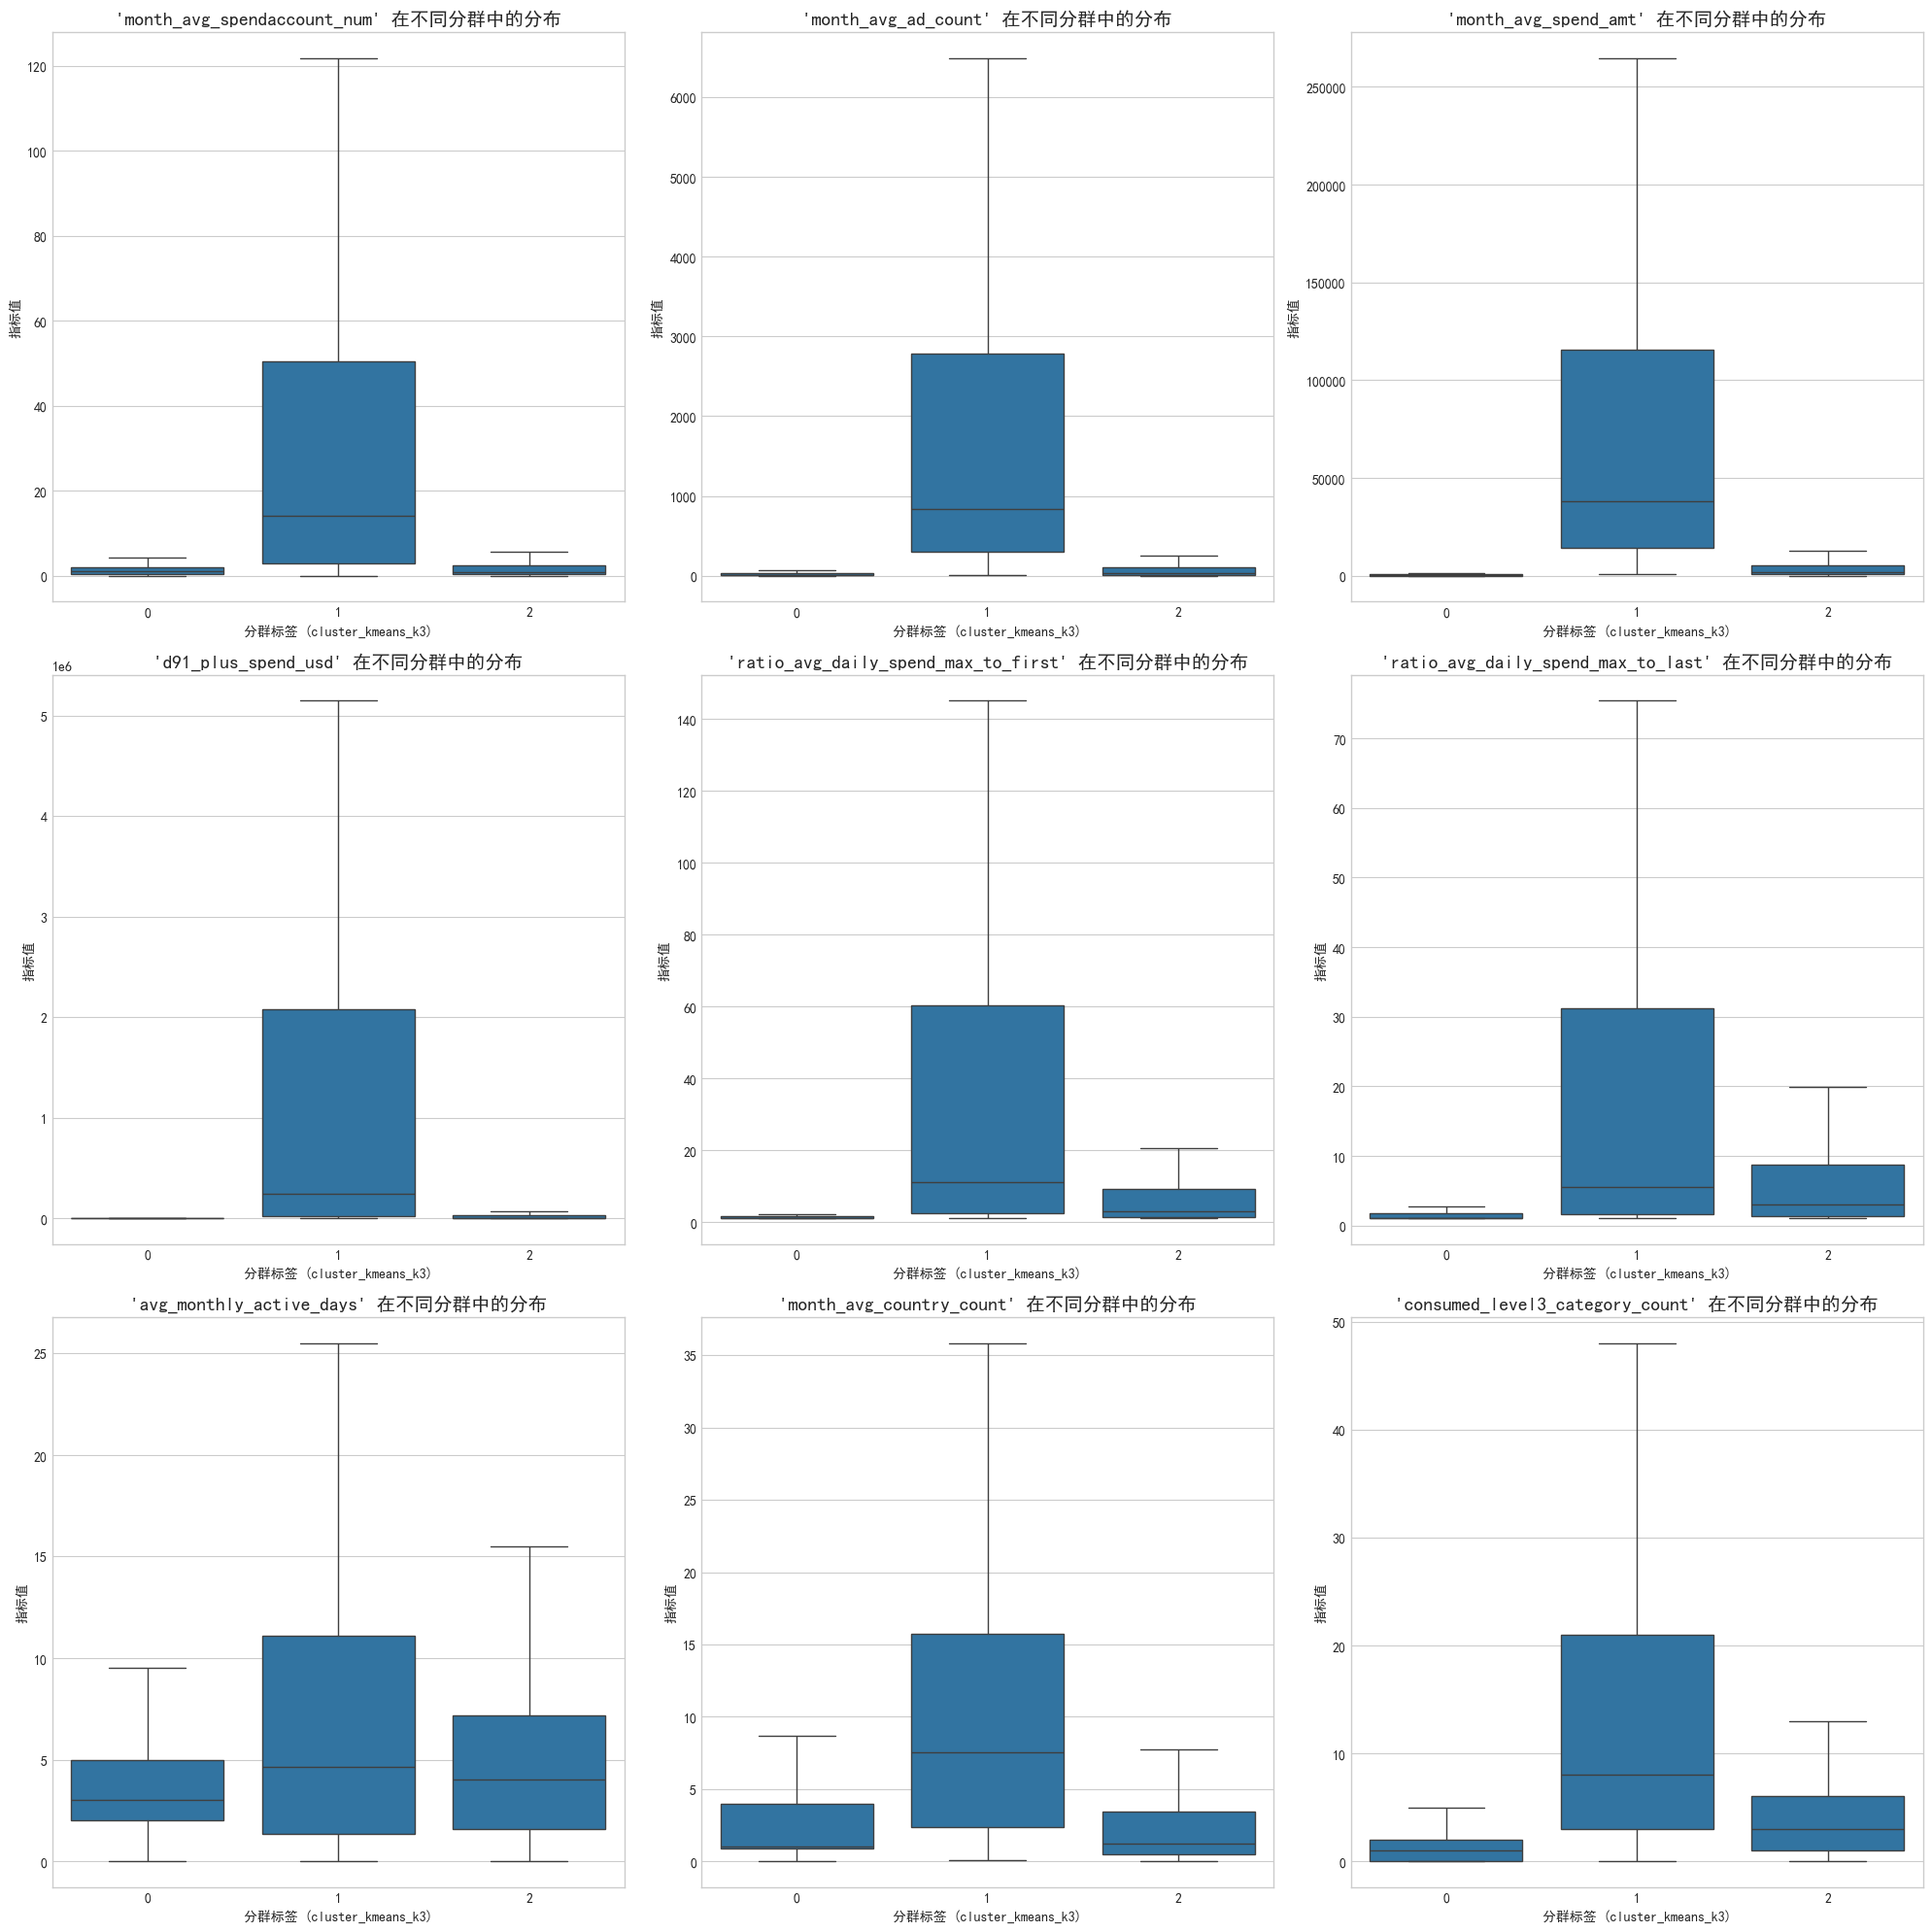

In [17]:
# ==============================================================================
# 可视化分析：9个核心指标的箱线图 (Box Plot) 分布对比
# ==============================================================================
print("\n" + "="*80)
print("                   3. 可视化分析：各分群指标分布对比")
print("="*80)

# **【核心修正】**: 创建一个3x3的子图网格，以容纳9张图
# 我们也调整了figsize，让整体布局更协调
fig, axes = plt.subplots(3, 3, figsize=(20, 20)) 
# 将2D的axes数组扁平化为1D，方便迭代
axes = axes.flatten()

# 假设 features_to_analyze 列表现在有9个字段
for i, col in enumerate(features_to_analyze):
    # 如果字段数量少于子图数量，我们只在需要的子图上绘图
    if i < len(axes):
        # 使用Seaborn绘制箱线图
        sns.boxplot(x=cluster_col, y=col, data=df_raw, ax=axes[i], showfliers=False)
        
        # 优化图表标题和标签
        axes[i].set_title(f"'{col}' 在不同分群中的分布", fontsize=14)
        axes[i].set_xlabel(f"分群标签 ({cluster_col})", fontsize=10)
        axes[i].set_ylabel("指标值", fontsize=10)

# 如果子图数量比特征多（例如3x3网格画8个图），隐藏多余的空图框
for j in range(len(features_to_analyze), len(axes)):
    axes[j].set_visible(False)
    
# 调整子图布局并显示
plt.tight_layout()
plt.show()

In [18]:
import pandas as pd
import numpy as np
from scipy import stats

# ==============================================================================
# 0. 准备工作：加载数据与定义辅助函数
# ==============================================================================
try:
    df_raw = pd.read_csv('df_k3_kmeans_all_raw.csv')
    df_desc = pd.read_csv('df_k3_kmeans_descriptive.csv')
    print("已成功加载 'df_k3_kmeans_all_raw.csv' 和 'df_k3_kmeans_descriptive.csv'")
except FileNotFoundError:
    print("错误：请确保相关CSV文件在当前目录。")
    exit()

def get_confidence_interval(data):
    """计算一维数据的均值和95%置信区间"""
    n = len(data)
    if n < 2:
        return np.mean(data), (np.nan, np.nan)
    mean = np.mean(data)
    se = stats.sem(data)
    # 增加对se为0的判断，防止t.interval报错
    if se > 0:
        ci = stats.t.interval(0.95, df=n-1, loc=mean, scale=se)
    else:
        ci = (mean, mean) # 如果标准误差为0，则置信区间上下限均为均值
    return mean, ci

cluster_col = 'cluster_kmeans_k3'
# 获取所有的簇标签
clusters = sorted(df_raw[cluster_col].unique())

# 初始化用于存储最终表格数据的列表
numeric_profile_data = []
# ==============================================================================
# 分群后对各核心数值指标的统计分析
# ==============================================================================
# ==============================================================================
# 1. 数值型特征画像 (重构为表格生成)
# ==============================================================================
print("\n正在生成数值型特征画像表...")

# --- 1a. 预先清洗所有需要计算的数值列 ---
numeric_cols_to_clean = [
    'month_avg_spendaccount_num', 'month_avg_ad_count', 'first_7d_spend_usd',
    'value_concentration_index_daily', 'month_avg_spend_amt', 'avg_monthly_active_days',
    'consumed_level3_category_count', 'days_since_last_spend','month_avg_country_count'
]
tier_map = {'90日以上启动投放': 1, '90日内启动投放': 2, '60日内启动投放': 3, '30日内启动投放': 4, '15日内启动投放': 5, '历史老客': 6}
df_raw['onboarding_intent_tier_encoded'] = df_raw['onboarding_intent_tier'].map(tier_map).fillna(0)
numeric_cols_to_clean.append('onboarding_intent_tier_encoded')

for col in numeric_cols_to_clean:
    df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce').fillna(0)

# --- 1b. 计算核心消费与活跃指标 ---
continuous_features = [
    'month_avg_spendaccount_num', 'month_avg_ad_count', 'first_7d_spend_usd',
    'value_concentration_index_daily', 'onboarding_intent_tier_encoded',
    'month_avg_spend_amt', 'avg_monthly_active_days',
    'consumed_level3_category_count', 'days_since_last_spend','month_avg_country_count'
]
for col in continuous_features:
    mean_row = {'指标类别': '核心消费与活跃', '指标名称': f'{col} (均值)'}
    ci_row = {'指标类别': '核心消费与活跃', '指标名称': f'{col} (95%置信区间)'}
    for cid in clusters:
        data = df_raw[col][df_raw[cluster_col] == cid]
        mean, ci = get_confidence_interval(data)
        mean_row[f'群组 {cid}'] = f"{mean:.2f}"
        ci_row[f'群组 {cid}'] = f"({ci[0]:.2f}, {ci[1]:.2f})"
    numeric_profile_data.extend([mean_row, ci_row])

# --- 1c. 分析业务背景 ---
biz_row = {'指标类别': '业务背景', '指标名称': 'Top 2 业务背景 (非Unknown)'}
for cid in clusters:
    cluster_data = df_raw[df_raw[cluster_col] == cid]
    biz_counts = cluster_data[cluster_data['business_background'] != 'Unknown']['business_background'].value_counts(normalize=True)
    if not biz_counts.empty:
        # 使用换行符 \n 来分隔，Excel中可以通过设置“自动换行”来美观地显示
        top2_str = "\n".join([f"{name}: {pct:.1%}" for name, pct in biz_counts.head(2).items()])
        biz_row[f'群组 {cid}'] = top2_str
    else:
        biz_row[f'群组 {cid}'] = "无"
numeric_profile_data.append(biz_row)

# --- 1d. 分析核心品类标签 ---
core_category_flags = ['is_core_category_clothing', 'is_core_category_accessories', 'is_core_category_beauty', 'is_core_category_electronics']
for col in core_category_flags:
    cat_row = {'指标类别': '核心品类', '指标名称': f'{col} (渗透率)'}
    for cid in clusters:
        penetration_rate = df_raw[col][df_raw[cluster_col] == cid].mean()
        cat_row[f'群组 {cid}'] = f"{penetration_rate:.2%}"
    numeric_profile_data.append(cat_row)

# --- 1e. 分析风险标签 ---
risk_flags = ['has_high_risk_flag_real_money', 'has_high_risk_flag_counterfeit', 'has_high_risk_flag_cheat', 'has_high_risk_flag_gambling']
risk_row = {'指标类别': '风险评估', '指标名称': '综合风险客户占比'}
for cid in clusters:
    any_risk_flag = df_raw[risk_flags][df_raw[cluster_col] == cid].any(axis=1)
    overall_risk_rate = any_risk_flag.mean()
    risk_row[f'群组 {cid}'] = f"{overall_risk_rate:.2%}"
numeric_profile_data.append(risk_row)

# 将数值型画像结果转换为DataFrame
numeric_profile_df = pd.DataFrame(numeric_profile_data)
# 增加一列客户数统计
counts = df_raw[cluster_col].value_counts().sort_index()
count_row = {'指标类别': '基本信息', '指标名称': '客户数 (Count)'}
for cid in clusters:
    count_row[f'群组 {cid}'] = counts[cid]
numeric_profile_df = pd.concat([pd.DataFrame([count_row]), numeric_profile_df], ignore_index=True)
numeric_profile_df.to_excel("output1.xlsx")

已成功加载 'df_k3_kmeans_all_raw.csv' 和 'df_k3_kmeans_descriptive.csv'

正在生成数值型特征画像表...


In [19]:
# ==============================================================================
# 分群后对各核心描述指标的统计分析
# ==============================================================================
# ==============================================================================
# 2. 描述型特征画像 (为了报告完整性，我们一并生成)
# ==============================================================================
print("\n正在生成描述型特征画像表...")
descriptive_profile_data = []

# Top N 文本特征
desc_features_top_n = {
    'top_l2_category': 3, 'top_l2_l3_combined': 3, 'top_custom_region_all': 3,
    'corporation_promotion_channel_second': 5, 'main_media': 2
}
for col, n in desc_features_top_n.items():
    desc_row = {'指标类别': 'Top N 偏好', '指标名称': f'Top {n} {col}'}
    for cid in clusters:
        # 定位到当前群组和列的数据
        series_to_count = df_desc.loc[df_desc[cluster_col] == cid, col]

        # 根据您的要求，对特定列进行数据清洗
        if col in ['top_l2_category', 'top_l2_l3_combined']:
            # 清洗掉 '未知'
            cleaned_series = series_to_count[series_to_count != '未知']
        elif col == 'corporation_promotion_channel_second':
            # 清洗掉 '其他' 和 'Unknown'
            cleaned_series = series_to_count[~series_to_count.isin(['其他', 'Unknown'])]
        else:
            # 其他列保持不变
            cleaned_series = series_to_count

        # 计算清洗后的 Top N
        counts = cleaned_series.dropna().value_counts().head(n)
        top_n_str = "\n".join([f"{name}: {count}" for name, count in counts.items()])
        desc_row[f'群组 {cid}'] = top_n_str
    descriptive_profile_data.append(desc_row)

# main_regions 特殊处理
regions_row = {'指标类别': 'Top N 偏好', '指标名称': 'Top 3 细分投放区域 (main_regions)'}
for cid in clusters:
    # 拆分并展开区域数据
    split_regions = df_desc['main_regions'][df_desc[cluster_col] == cid].dropna().str.split('_').explode()
    
    # 根据您的要求，清洗掉 '未知'
    cleaned_regions = split_regions[split_regions != '未知']
    
    # 计算清洗后的 Top 3
    top_regions_str = "\n".join([f"{name}: {count}" for name, count in cleaned_regions.value_counts().head(3).items()])
    regions_row[f'群组 {cid}'] = top_regions_str
descriptive_profile_data.append(regions_row)

# 生成并保存 Excel 文件
descriptive_profile_df = pd.DataFrame(descriptive_profile_data)
descriptive_profile_df.to_excel("output2.xlsx", index=False)

print("描述型特征画像表 (output2.xlsx) 已成功生成。")


正在生成描述型特征画像表...
描述型特征画像表 (output2.xlsx) 已成功生成。


In [20]:
# ==============================================================================
# K = 4时开始聚类，模型：Kmeans
# ==============================================================================
from sklearn.cluster import KMeans
import pandas as pd

# 假设 feature_set_A_pca, df, df_transformed, df_descriptive
# 这些DataFrame都已在您当前的Jupyter Notebook环境中成功生成并存在

print("--- Iteration 2: K-Means (K=4) ---")

# 1. 初始化模型
# 我们选择 n_clusters=4，因为这是我们的目标分群数
# n_init='auto' 是新版sklearn的推荐设置，能自动选择最佳初始化次数
# random_state=42 确保每次运行结果都一样，便于复现
kmeans_k4 = KMeans(n_clusters=4, random_state=42, n_init='auto')

# 2. 在PCA降维后的数据上进行拟合和预测
# .fit_predict() 会直接返回每个数据点所属的簇标签
print("正在对 feature_set_A_pca 进行K-Means聚类 (K=4)...")
labels_kmeans_k4 = kmeans_k4.fit_predict(feature_set_A_pca)
print("聚类执行完成！")


# 3. 统计每个分群的客户数量
cluster_counts = pd.Series(labels_kmeans_k4).value_counts().sort_index()
print("\n每个分群的客户数量分布:")
print(cluster_counts)

# ==============================================================================
# 4. 将聚类结果保存起来，以便后续的画像分析
# ==============================================================================
# 创建新的列名，以反映这是Iteration 2的结果
new_cluster_col_name = 'cluster_kmeans_k4'

# 将聚类标签直接添加到最原始的'df' DataFrame中
df[new_cluster_col_name] = labels_kmeans_k4

print(f"\n已将K=3的聚类标签 ({new_cluster_col_name}) 添加到原始信息表'df'中，用于后续画像。")
print("原始信息表'df'预览 (已包含聚类标签):")

# 为了更好地预览，我们只显示部分关键列和新添加的标签列
preview_cols = ['corporation_id', 'month_avg_spend_amt', 'corporation_size', 'main_media', new_cluster_col_name]
print(df[preview_cols].head())

# 同时，也在df_transformed和df_descriptive上打上标签并保存
df_transformed[new_cluster_col_name] = labels_kmeans_k4
df_descriptive[new_cluster_col_name] = labels_kmeans_k4

# 保存三个版本的数据文件，文件名清晰地反映了本次迭代的内容
df.to_csv('df_k4_kmeans_all_raw.csv', index=False)
df_transformed.to_csv('df_k4_kmeans_all_transformed.csv', index=False)
df_descriptive.to_csv('df_k4_kmeans_descriptive.csv', index=False)

print("\n已成功将Iteration 2 (K=4, K-Means) 的三个版本的数据表保存到本地CSV文件。")

--- Iteration 2: K-Means (K=4) ---
正在对 feature_set_A_pca 进行K-Means聚类 (K=4)...
聚类执行完成！

每个分群的客户数量分布:
0    3715
1    1189
2    3639
3    1456
Name: count, dtype: int64

已将K=3的聚类标签 (cluster_kmeans_k4) 添加到原始信息表'df'中，用于后续画像。
原始信息表'df'预览 (已包含聚类标签):
   corporation_id  month_avg_spend_amt corporation_size main_media  cluster_kmeans_k4
0          258607        213086.140000               KA  Mintegral                  3
1          301251           107.820000              SMB     TikTok                  0
2          277412          1569.696667              SMB   Facebook                  2
3          299621          2754.174000              SMB   Facebook                  2
4          298842           150.015000              SMB   Facebook                  0

已成功将Iteration 2 (K=4, K-Means) 的三个版本的数据表保存到本地CSV文件。


In [21]:
# ==============================================================================
# 挑出这九个核心指标（和业务谈论过的），做一下数据上的统计。
# ==============================================================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

# ==============================================================================
# 0. 准备工作：加载数据与设置
# ==============================================================================
# 加载包含了原始数据和K=4 K-Means聚类标签的文件
df_raw = pd.read_csv('df_k4_kmeans_all_raw.csv')

# 解决matplotlib中文显示问题

plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False

# 您指定需要分析的核心字段，从上面的共线性的簇群来挑选最符合业务的
features_to_analyze = [
    'month_avg_spendaccount_num', 'month_avg_ad_count', 
    'month_avg_spend_amt', 'd91_plus_spend_usd', 
    'ratio_avg_daily_spend_max_to_first', 'ratio_avg_daily_spend_max_to_last', 
    'avg_monthly_active_days', 'month_avg_country_count','consumed_level3_category_count'
]

# 聚类标签列名
cluster_col = 'cluster_kmeans_k4'

# **【核心修正】**: 在进行聚合前，强制将所有待分析的列转换为数值类型
for col in features_to_analyze:
    # errors='coerce' 会将无法转换的值变为NaN
    df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce')
    # 用0填充可能产生的NaN
    df_raw[col] = df_raw[col].fillna(0)


# ==============================================================================
# 1. 描述性统计分析：各分群指标均值与中位数对比
# ==============================================================================
print("\n" + "="*80)
print("              1. 描述性统计分析：各分群核心指标对比")
print("="*80)

# 使用groupby和agg计算每个群在指定字段上的核心统计量
profile_summary = df_raw.groupby(cluster_col)[features_to_analyze].agg(['mean', 'median', 'std', 'count'])
print(profile_summary)


              1. 描述性统计分析：各分群核心指标对比
                  month_avg_spendaccount_num                          month_avg_ad_count                                  month_avg_spend_amt                                   d91_plus_spend_usd  \
                                        mean median         std count               mean       median           std count                mean       median            std count               mean   
cluster_kmeans_k4                                                                                                                                                                                    
0                                   2.252225   1.00    4.365586  3715          63.149817     8.285714    327.421399  3715          856.988978    198.07500    2819.772377  3715       1.236747e+02   
1                                  70.081157  38.00  113.165440  1189        7062.516540  1379.333333  24370.047539  1189        93478.077268  20430.38706  969014.497173  1

In [22]:
# =============================================================================
# 从统计学上判断每个核心指标的差异率
# =============================================================================
# ==============================================================================
# 2. 推断性统计分析：ANOVA方差分析
# ==============================================================================
print("\n" + "="*80)
print("    2. 推断性统计分析：ANOVA方差分析 (检验各指标在分群间的差异显著性)")
print("="*80)
print("F统计量越大，p值越小（通常<0.05），说明该指标在三个群体间的差异越显著。")
print("-" * 80)

anova_results = {}
for col in features_to_analyze:
    # 准备每个群在该特征上的数据
    groups = [df_raw[col][df_raw[cluster_col] == i] for i in df_raw[cluster_col].unique()]
    
    # 执行ANOVA F检验
    f_statistic, p_value = f_oneway(*groups)
    anova_results[col] = {'F-statistic': f_statistic, 'p-value': p_value}
    
    print(f"指标: {col}")
    print(f"  F-statistic: {f_statistic:.2f}")
    print(f"  p-value: {p_value:.4g} {'(差异极显著)' if p_value < 0.05 else '(差异不显著)'}")


    2. 推断性统计分析：ANOVA方差分析 (检验各指标在分群间的差异显著性)
F统计量越大，p值越小（通常<0.05），说明该指标在三个群体间的差异越显著。
--------------------------------------------------------------------------------
指标: month_avg_spendaccount_num
  F-statistic: 1027.82
  p-value: 0 (差异极显著)
指标: month_avg_ad_count
  F-statistic: 190.01
  p-value: 7.722e-120 (差异极显著)
指标: month_avg_spend_amt
  F-statistic: 80.08
  p-value: 3.432e-51 (差异极显著)
指标: d91_plus_spend_usd
  F-statistic: 92.88
  p-value: 2.78e-59 (差异极显著)
指标: ratio_avg_daily_spend_max_to_first
  F-statistic: 10.22
  p-value: 1.019e-06 (差异极显著)
指标: ratio_avg_daily_spend_max_to_last
  F-statistic: 16.08
  p-value: 2.012e-10 (差异极显著)
指标: avg_monthly_active_days
  F-statistic: 928.13
  p-value: 0 (差异极显著)
指标: month_avg_country_count
  F-statistic: 357.02
  p-value: 2.835e-220 (差异极显著)
指标: consumed_level3_category_count
  F-statistic: 1034.78
  p-value: 0 (差异极显著)



                   3. 可视化分析：各分群指标分布对比


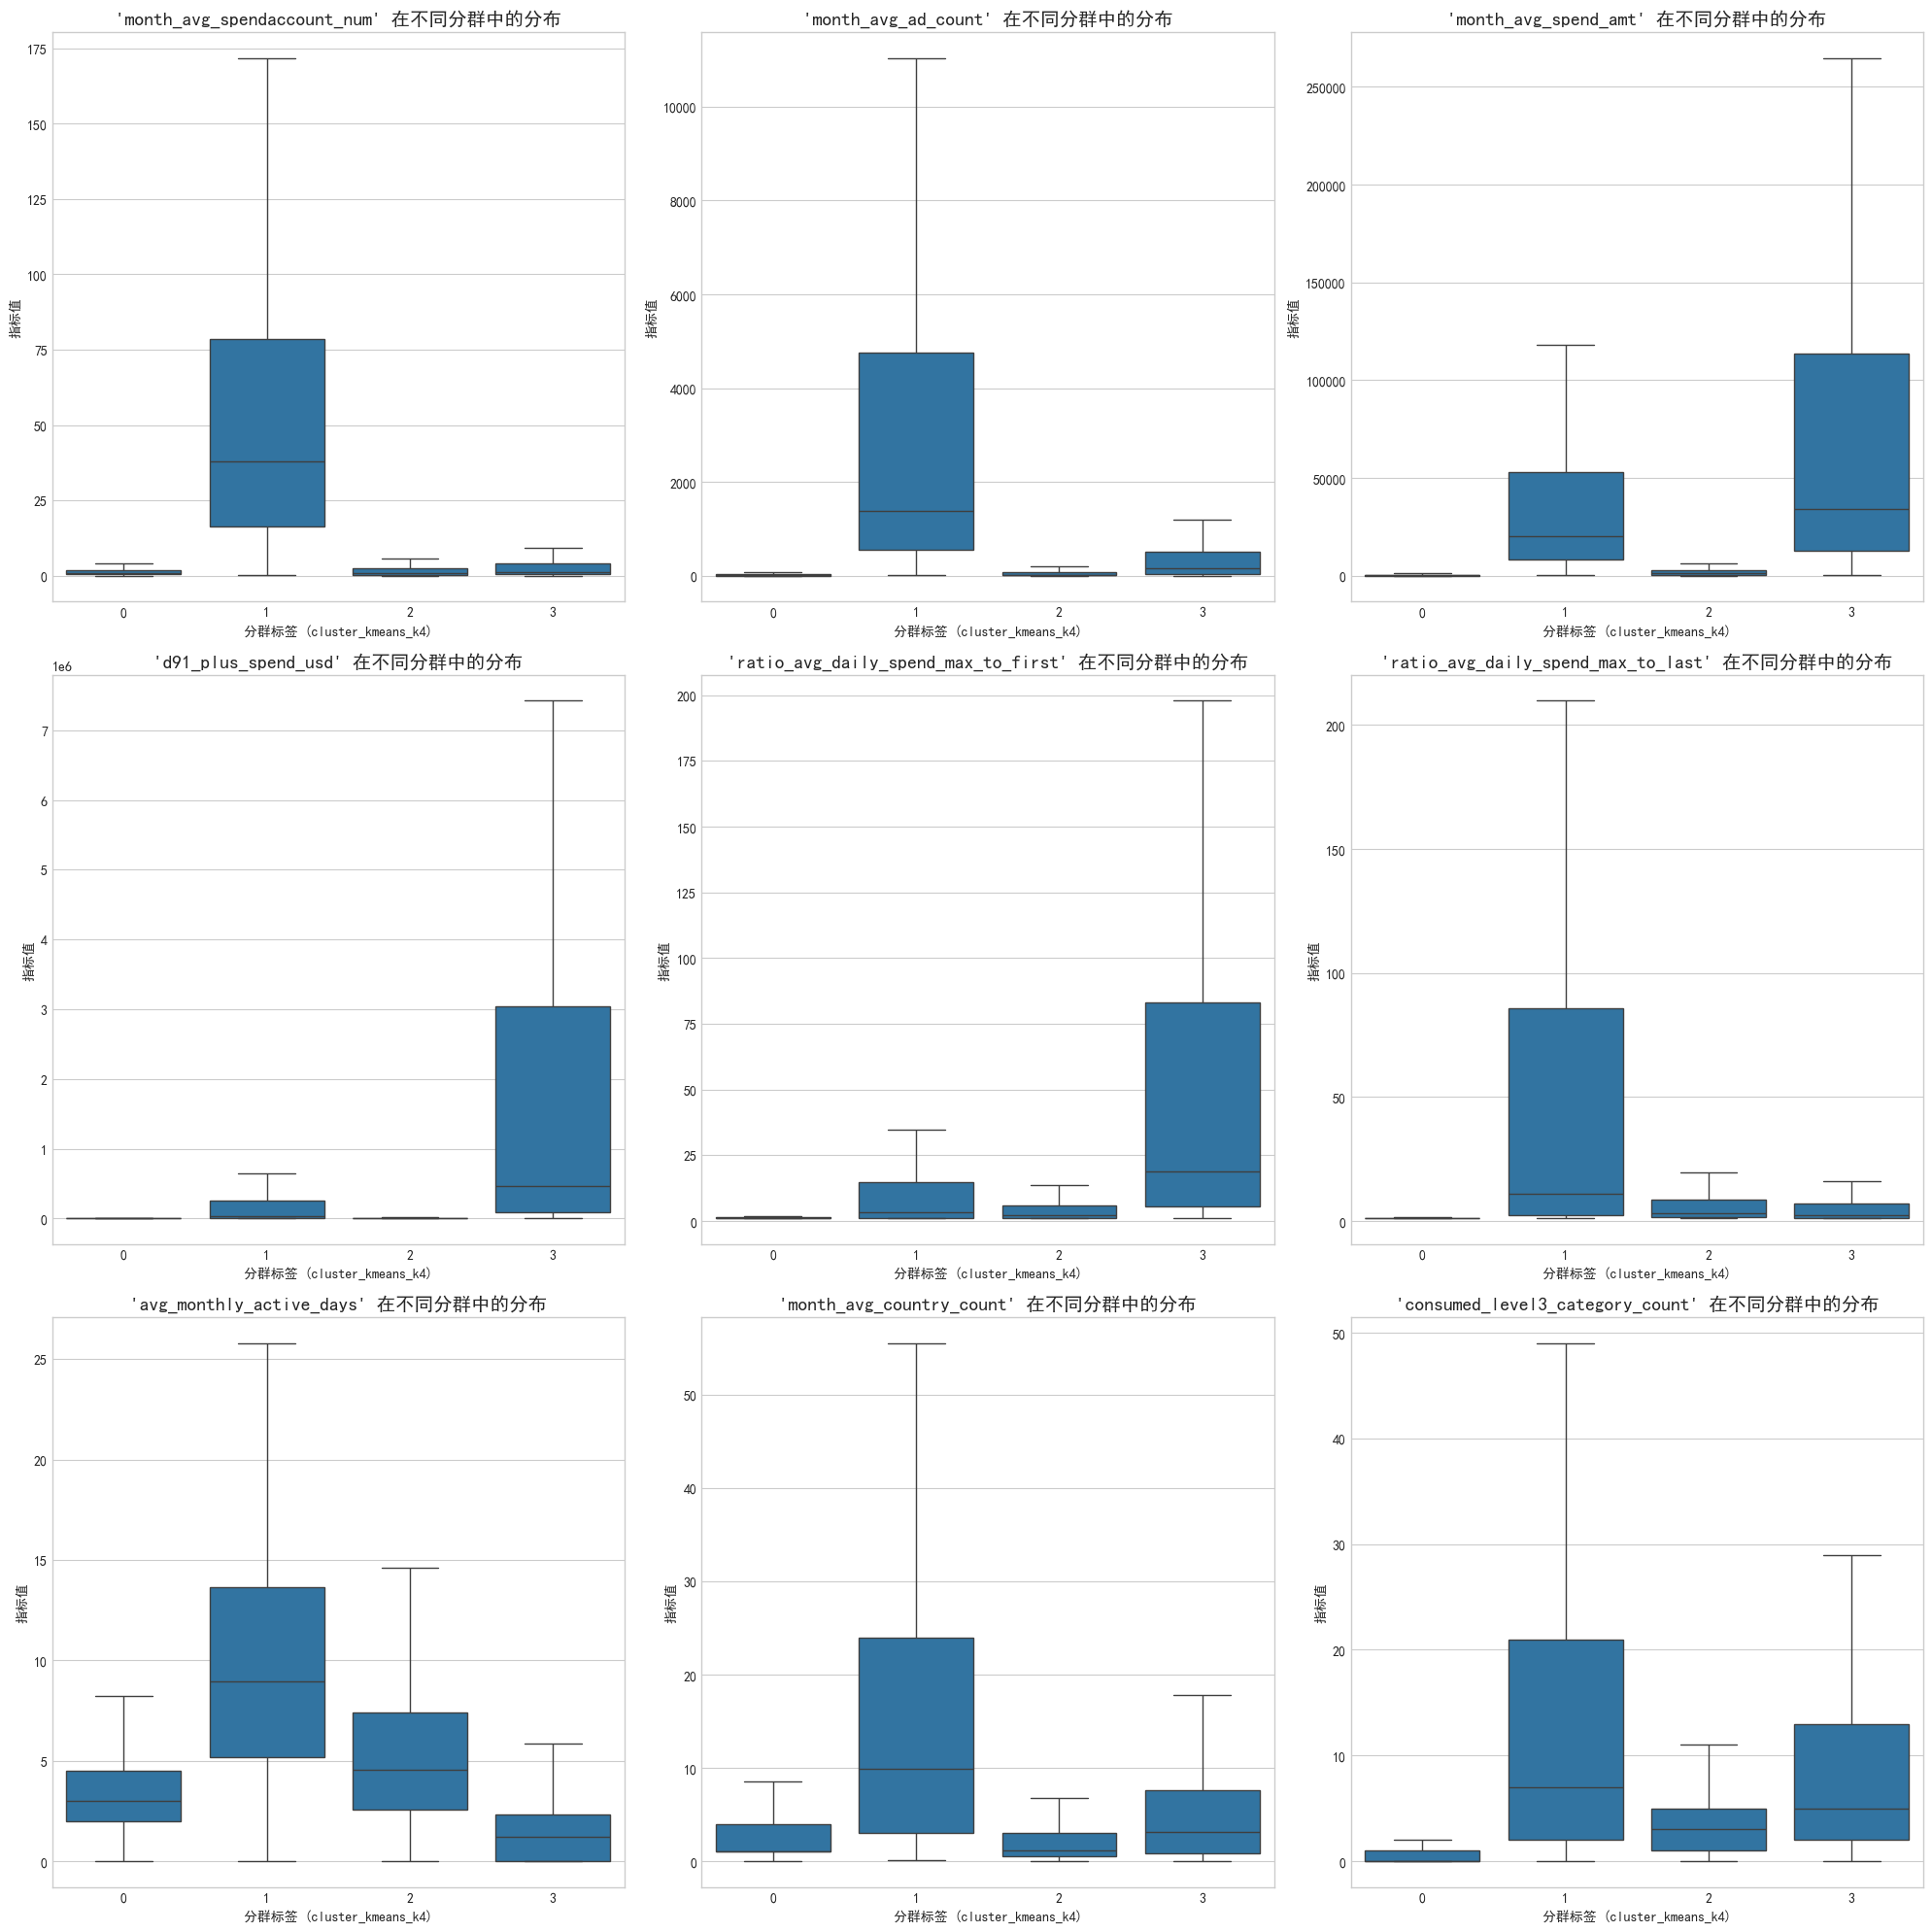

In [23]:
# ==============================================================================
# 可视化分析：9个核心指标的箱线图 (Box Plot) 分布对比
# ==============================================================================
print("\n" + "="*80)
print("                   3. 可视化分析：各分群指标分布对比")
print("="*80)

# **【核心修正】**: 创建一个3x3的子图网格，以容纳9张图
# 我们也调整了figsize，让整体布局更协调
fig, axes = plt.subplots(3, 3, figsize=(20, 20)) 
# 将2D的axes数组扁平化为1D，方便迭代
axes = axes.flatten()

# 假设 features_to_analyze 列表现在有9个字段
for i, col in enumerate(features_to_analyze):
    # 如果字段数量少于子图数量，我们只在需要的子图上绘图
    if i < len(axes):
        # 使用Seaborn绘制箱线图
        sns.boxplot(x=cluster_col, y=col, data=df_raw, ax=axes[i], showfliers=False)
        
        # 优化图表标题和标签
        axes[i].set_title(f"'{col}' 在不同分群中的分布", fontsize=14)
        axes[i].set_xlabel(f"分群标签 ({cluster_col})", fontsize=10)
        axes[i].set_ylabel("指标值", fontsize=10)

# 如果子图数量比特征多（例如3x3网格画8个图），隐藏多余的空图框
for j in range(len(features_to_analyze), len(axes)):
    axes[j].set_visible(False)
    
# 调整子图布局并显示
plt.tight_layout()
plt.show()

In [24]:
import pandas as pd
import numpy as np
from scipy import stats

# ==============================================================================
# 0. 准备工作：加载数据与定义辅助函数
# ==============================================================================
try:
    df_raw = pd.read_csv('df_k4_kmeans_all_raw.csv')
    df_desc = pd.read_csv('df_k4_kmeans_descriptive.csv')
    print("已成功加载 'df_k4_kmeans_all_raw.csv' 和 'df_k4_kmeans_descriptive.csv'")
except FileNotFoundError:
    print("错误：请确保相关CSV文件在当前目录。")
    exit()

def get_confidence_interval(data):
    """计算一维数据的均值和95%置信区间"""
    n = len(data)
    if n < 2:
        return np.mean(data), (np.nan, np.nan)
    mean = np.mean(data)
    se = stats.sem(data)
    # 增加对se为0的判断，防止t.interval报错
    if se > 0:
        ci = stats.t.interval(0.95, df=n-1, loc=mean, scale=se)
    else:
        ci = (mean, mean) # 如果标准误差为0，则置信区间上下限均为均值
    return mean, ci

cluster_col = 'cluster_kmeans_k4'
# 获取所有的簇标签
clusters = sorted(df_raw[cluster_col].unique())

# 初始化用于存储最终表格数据的列表
numeric_profile_data = []
# ==============================================================================
# 分群后对各核心数值指标的统计分析
# ==============================================================================
# ==============================================================================
# 1. 数值型特征画像 (重构为表格生成)
# ==============================================================================
print("\n正在生成数值型特征画像表...")

# --- 1a. 预先清洗所有需要计算的数值列 ---
numeric_cols_to_clean = [
    'month_avg_spendaccount_num', 'month_avg_ad_count', 'first_7d_spend_usd',
    'value_concentration_index_daily', 'month_avg_spend_amt', 'avg_monthly_active_days',
    'consumed_level3_category_count', 'days_since_last_spend','month_avg_country_count'
]
tier_map = {'90日以上启动投放': 1, '90日内启动投放': 2, '60日内启动投放': 3, '30日内启动投放': 4, '15日内启动投放': 5, '历史老客': 6}
df_raw['onboarding_intent_tier_encoded'] = df_raw['onboarding_intent_tier'].map(tier_map).fillna(0)
numeric_cols_to_clean.append('onboarding_intent_tier_encoded')

for col in numeric_cols_to_clean:
    df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce').fillna(0)

# --- 1b. 计算核心消费与活跃指标 ---
continuous_features = [
    'month_avg_spendaccount_num', 'month_avg_ad_count', 'first_7d_spend_usd',
    'value_concentration_index_daily', 'onboarding_intent_tier_encoded',
    'month_avg_spend_amt', 'avg_monthly_active_days',
    'consumed_level3_category_count', 'days_since_last_spend','month_avg_country_count'
]
for col in continuous_features:
    mean_row = {'指标类别': '核心消费与活跃', '指标名称': f'{col} (均值)'}
    ci_row = {'指标类别': '核心消费与活跃', '指标名称': f'{col} (95%置信区间)'}
    for cid in clusters:
        data = df_raw[col][df_raw[cluster_col] == cid]
        mean, ci = get_confidence_interval(data)
        mean_row[f'群组 {cid}'] = f"{mean:.2f}"
        ci_row[f'群组 {cid}'] = f"({ci[0]:.2f}, {ci[1]:.2f})"
    numeric_profile_data.extend([mean_row, ci_row])

# --- 1c. 分析业务背景 ---
biz_row = {'指标类别': '业务背景', '指标名称': 'Top 2 业务背景 (非Unknown)'}
for cid in clusters:
    cluster_data = df_raw[df_raw[cluster_col] == cid]
    biz_counts = cluster_data[cluster_data['business_background'] != 'Unknown']['business_background'].value_counts(normalize=True)
    if not biz_counts.empty:
        # 使用换行符 \n 来分隔，Excel中可以通过设置“自动换行”来美观地显示
        top2_str = "\n".join([f"{name}: {pct:.1%}" for name, pct in biz_counts.head(2).items()])
        biz_row[f'群组 {cid}'] = top2_str
    else:
        biz_row[f'群组 {cid}'] = "无"
numeric_profile_data.append(biz_row)

# --- 1d. 分析核心品类标签 ---
core_category_flags = ['is_core_category_clothing', 'is_core_category_accessories', 'is_core_category_beauty', 'is_core_category_electronics']
for col in core_category_flags:
    cat_row = {'指标类别': '核心品类', '指标名称': f'{col} (渗透率)'}
    for cid in clusters:
        penetration_rate = df_raw[col][df_raw[cluster_col] == cid].mean()
        cat_row[f'群组 {cid}'] = f"{penetration_rate:.2%}"
    numeric_profile_data.append(cat_row)

# --- 1e. 分析风险标签 ---
risk_flags = ['has_high_risk_flag_real_money', 'has_high_risk_flag_counterfeit', 'has_high_risk_flag_cheat', 'has_high_risk_flag_gambling']
risk_row = {'指标类别': '风险评估', '指标名称': '综合风险客户占比'}
for cid in clusters:
    any_risk_flag = df_raw[risk_flags][df_raw[cluster_col] == cid].any(axis=1)
    overall_risk_rate = any_risk_flag.mean()
    risk_row[f'群组 {cid}'] = f"{overall_risk_rate:.2%}"
numeric_profile_data.append(risk_row)

# 将数值型画像结果转换为DataFrame
numeric_profile_df = pd.DataFrame(numeric_profile_data)
# 增加一列客户数统计
counts = df_raw[cluster_col].value_counts().sort_index()
count_row = {'指标类别': '基本信息', '指标名称': '客户数 (Count)'}
for cid in clusters:
    count_row[f'群组 {cid}'] = counts[cid]
numeric_profile_df = pd.concat([pd.DataFrame([count_row]), numeric_profile_df], ignore_index=True)
numeric_profile_df.to_excel("output1.xlsx")

已成功加载 'df_k4_kmeans_all_raw.csv' 和 'df_k4_kmeans_descriptive.csv'

正在生成数值型特征画像表...


In [25]:
# ==============================================================================
# 分群后对各核心描述指标的统计分析
# ==============================================================================
# ==============================================================================
# 2. 描述型特征画像 (为了报告完整性，我们一并生成)
# ==============================================================================
print("\n正在生成描述型特征画像表...")
descriptive_profile_data = []

# Top N 文本特征
desc_features_top_n = {
    'top_l2_category': 3, 'top_l2_l3_combined': 3, 'top_custom_region_all': 3,
    'corporation_promotion_channel_second': 5, 'main_media': 2
}
for col, n in desc_features_top_n.items():
    desc_row = {'指标类别': 'Top N 偏好', '指标名称': f'Top {n} {col}'}
    for cid in clusters:
        # 定位到当前群组和列的数据
        series_to_count = df_desc.loc[df_desc[cluster_col] == cid, col]

        # 根据您的要求，对特定列进行数据清洗
        if col in ['top_l2_category', 'top_l2_l3_combined']:
            # 清洗掉 '未知'
            cleaned_series = series_to_count[series_to_count != '未知']
        elif col == 'corporation_promotion_channel_second':
            # 清洗掉 '其他' 和 'Unknown'
            cleaned_series = series_to_count[~series_to_count.isin(['其他', 'Unknown'])]
        else:
            # 其他列保持不变
            cleaned_series = series_to_count

        # 计算清洗后的 Top N
        counts = cleaned_series.dropna().value_counts().head(n)
        top_n_str = "\n".join([f"{name}: {count}" for name, count in counts.items()])
        desc_row[f'群组 {cid}'] = top_n_str
    descriptive_profile_data.append(desc_row)

# main_regions 特殊处理
regions_row = {'指标类别': 'Top N 偏好', '指标名称': 'Top 3 细分投放区域 (main_regions)'}
for cid in clusters:
    # 拆分并展开区域数据
    split_regions = df_desc['main_regions'][df_desc[cluster_col] == cid].dropna().str.split('_').explode()
    
    # 根据您的要求，清洗掉 '未知'
    cleaned_regions = split_regions[split_regions != '未知']
    
    # 计算清洗后的 Top 3
    top_regions_str = "\n".join([f"{name}: {count}" for name, count in cleaned_regions.value_counts().head(3).items()])
    regions_row[f'群组 {cid}'] = top_regions_str
descriptive_profile_data.append(regions_row)

# 生成并保存 Excel 文件
descriptive_profile_df = pd.DataFrame(descriptive_profile_data)
descriptive_profile_df.to_excel("output2.xlsx", index=False)

print("描述型特征画像表 (output2.xlsx) 已成功生成。")


正在生成描述型特征画像表...
描述型特征画像表 (output2.xlsx) 已成功生成。


In [26]:
# ==============================================
# 把output1和output2合并成一个Excel文件，就是我们最终画像的所有数值表。
# ==============================================